In [1]:
import os

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)

In [2]:
import keras
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Optimizer
from keras import callbacks
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional,concatenate
from keras.models import Model
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from keras.optimizers import Adam
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

np.random.seed(17)


import sys
import csv
from sklearn.ensemble import GradientBoostingClassifier
from feature_engineering import refuting_features, polarity_features, hand_features, gen_or_load_feats
from feature_engineering import word_overlap_features
from utils.dataset import DataSet
from utils.generate_test_splits import kfold_split, get_stances_for_folds
from utils.score import report_score, LABELS, score_submission
from csv import DictReader
from csv import DictWriter
import codecs

from utils.system import parse_params, check_version

Using TensorFlow backend.


# Load data

In [3]:
train_bodies = pd.read_csv('./fnc-1/train_bodies.csv')
    
train_stances = pd.read_csv('./fnc-1/train_stances.csv')

test_bodies = pd.read_csv('./fnc-1/competition_test_bodies.csv')

test_stances = pd.read_csv('./fnc-1/competition_test_stances.csv')

# Merge and concate

In [4]:
train_stances['Stance'].replace('agree',0,True)
train_stances['Stance'].replace('disagree',1,True)
train_stances['Stance'].replace('discuss',2,True)
train_stances['Stance'].replace('unrelated',3,True)

train_merge = pd.merge(train_stances, train_bodies, on='Body ID')

test_stances['Stance'].replace('agree',0,True)
test_stances['Stance'].replace('disagree',1,True)
test_stances['Stance'].replace('discuss',2,True)
test_merge = pd.merge(test_stances, test_bodies, on='Body ID')
test_stances['Stance'].replace('unrelated',3,True)
#train_merge.head(10)
test_merge.head(10)

,Headline,Body ID,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,2008,3,A RESPECTED senior French police officer inves...
1,Apple Stores to install safes to secure gold A...,2008,3,A RESPECTED senior French police officer inves...
2,Pregnant woman loses eye after police shoot be...,2008,3,A RESPECTED senior French police officer inves...
3,We just found out the #Ferguson Protester who ...,2008,3,A RESPECTED senior French police officer inves...
4,Police Chief In Charge of Paris Attacks Commit...,2008,2,A RESPECTED senior French police officer inves...
5,Ferguson protester shot in the eye with rubber...,2008,3,A RESPECTED senior French police officer inves...
6,Pregnant Ferguson woman loses her EYE after po...,2008,3,A RESPECTED senior French police officer inves...
7,Pregnant woman loses eye after Ferguson cops f...,2008,3,A RESPECTED senior French police officer inves...
8,Police officer in Charlie Hebdo investigation ...,2008,2,A RESPECTED senior French police officer inves...
9,Pregnant Woman Loses Eye During Ferguson Riots...,2008,3,A RESPECTED senior French police officer inves...


In [5]:
MAX_SENT_LEN = 16
MAX_VOCAB_SIZE = 50000
LSTM_DIM = 100
EMBEDDING_DIM = 50
BATCH_SIZE = 128
N_EPOCHS = 1
MAX_SENT_LEN1 = 100
MAX_VOCAB_SIZE1 = 50000


train_merge['Headline'].head(10)

test_merge['Headline'] = test_merge['Headline'].apply(lambda x: str(x))
train_merge['Headline'] = train_merge['Headline'].apply(lambda x: str(x))

test_merge['articleBody'] = test_merge['articleBody'].apply(lambda x: str(x))
train_merge['articleBody'] = train_merge['articleBody'].apply(lambda x: str(x))


train_merge = train_merge.sample(frac=1, random_state=10)


word_seq_train_stances = [text_to_word_sequence(head) for head in train_merge['Headline']]
word_seq_train_bodies = [text_to_word_sequence(body) for body in train_merge['articleBody']]



word_seq_test_stances = [text_to_word_sequence(head) for head in test_merge['Headline']]
word_seq_test_bodies = [text_to_word_sequence(body) for body in test_merge['articleBody']]

# Create a list for embedding

In [6]:
word_seq = []

for i in range(len(word_seq_train_stances)):
    word_seq.append(word_seq_train_stances[i])
for i in range(len(word_seq_train_bodies)):
    word_seq.append(word_seq_train_bodies[i])


for i in range(len(word_seq_test_stances)):
    word_seq.append(word_seq_test_stances[i])
for i in range(len(word_seq_test_bodies)):
    word_seq.append(word_seq_test_bodies[i])

In [7]:
word_seq_train_bodies[:10]

[['a',
  'desperate',
  'mother',
  'was',
  'tricked',
  'into',
  'feasting',
  'on',
  'cooked',
  'meat',
  'from',
  'the',
  'body',
  'of',
  'her',
  'son',
  'by',
  'islamic',
  'state',
  'militants',
  'it',
  'has',
  'been',
  'claimed',
  '\r',
  '\r',
  'the',
  'famished',
  'kurdish',
  'mother',
  'had',
  'gone',
  'to',
  'plead',
  'with',
  'the',
  'jihadists',
  'to',
  'release',
  'her',
  'son',
  '\r',
  '\r',
  'cruel',
  'militants',
  'delayed',
  'talks',
  'with',
  'the',
  'elderly',
  'mum',
  '–',
  'feeding',
  'her',
  'a',
  'meal',
  'made',
  'with',
  'the',
  'corpse',
  'of',
  'her',
  'offspring',
  'while',
  'she',
  'waited',
  '\r',
  '\r',
  'the',
  'depraved',
  'story',
  'was',
  'relayed',
  'by',
  'a',
  'brave',
  'briton',
  'fighting',
  'on',
  'the',
  'front',
  'line',
  'with',
  'kurdish',
  'forces',
  'against',
  'the',
  'islamic',
  'state',
  'also',
  'referred',
  'to',
  'as',
  'is',
  'isis',
  'and',
  'is

In [13]:

print('75th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq_train_stances], 75))
print('75th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq_train_bodies], 75))


75th Percentile Sentence Length: 13.0
75th Percentile Sentence Length: 500.0


# Pass the words through tokenizer

In [14]:

filter_list = '\r\t\n'
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,filters=filter_list)
tokenizer.fit_on_texts([seq for seq in word_seq])
print("Number of words in vocabulary:", len(tokenizer.word_index))

tokenizer.word_index

X = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_train_stances])
X = pad_sequences(X, maxlen=MAX_SENT_LEN, padding='post', truncating='post')


Number of words in vocabulary: 37466


In [15]:
X[:3]

array([[   31,    86,     5,   794,   246,   737,     6,   107,  3289,
            0,     0,     0,     0,     0,     0,     0],
       [ 1743,  1334,  2292,    24,   929,  8442,     4,   282,   914,
            6,   745,   234,     4, 25179,     0,     0],
       [   69,    54,   134,   320,     3,  3678,   219,   116,   161,
            0,     0,     0,     0,     0,     0,     0]])

In [16]:
X1 = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN1]) for seq in word_seq_train_bodies])
X1 = pad_sequences(X1, maxlen=MAX_SENT_LEN1, padding='post', truncating='post')

In [17]:
X_test_bodies = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN1]) for seq in word_seq_test_bodies])
X_test_bodies = pad_sequences(X_test_bodies, maxlen=MAX_SENT_LEN1, padding='post', truncating='post')

In [18]:
X_test_bodies[:3]

array([[   4, 4681,  536, 1115,   91,  328, 1265,    1, 1495, 2137,  905,
        2331,  182,   19,  270,  166, 7201,  537,   37,    1, 2957,  504,
        2908,    1,  183, 1698, 3225, 2090, 2102,  601,    4, 1157,   11,
         441,    6,   19,   91,  291,    6, 3267,   83,  314,  296,   97,
        1490,  501,    4, 2935,  168,   19,  395,   24, 8827,   11,  466,
           1,  162,   37,  132, 2177,  498,   24,    1, 2027, 5742,  291,
           7,  195,  331,   65,  269,  831,    3,  137,  790, 1448, 1412,
         312,    1, 1923,    5, 5104,    5,    1,  255,   91,  205,  164,
        2090,   32,  197,   19,  270,  166,    0,    0,    0,    0,    0,
           0],
       [   4, 4681,  536, 1115,   91,  328, 1265,    1, 1495, 2137,  905,
        2331,  182,   19,  270,  166, 7201,  537,   37,    1, 2957,  504,
        2908,    1,  183, 1698, 3225, 2090, 2102,  601,    4, 1157,   11,
         441,    6,   19,   91,  291,    6, 3267,   83,  314,  296,   97,
        1490,  501,    

In [19]:
X_test_stances = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_test_stances])
X_test_stances = pad_sequences(X_test_stances, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

# Split train validation data

In [20]:
y = train_merge['Stance']

encoder_train = LabelEncoder()
encoder_train.fit(y)
encoded_train = encoder_train.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)

y_test = test_merge['Stance']



train_size =math.ceil( X.shape[0] * 0.9)
train_size_end =math.ceil( X.shape[0] * 0.2)

X_train = X[0:train_size]
X1_train = X1[0:train_size]

X_val = X[train_size:]
X1_val = X1[train_size:]

y_train = dummy_y_train[0:train_size]
y_val = dummy_y_train[train_size:]

print(X_train.shape)
print(X1_train.shape)
print(y_train.shape)

print(X_val.shape)
print(X1_val.shape)
print(y_val.shape)

(44975, 16)
(44975, 100)
(44975, 4)
(4997, 16)
(4997, 100)
(4997, 4)


# import Glove embeddings

In [22]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

glove_input_file = 'd:/641/glove.twitter.27B.50d.txt'
word2vec_output_file = 'glove.500d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)



D:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
D:\anaconda\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(1193514, 50)

In [23]:
# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

# Generate 2 models for headline and article body seperately

In [24]:
from keras.models import Sequential
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], 
                          input_length=MAX_SENT_LEN,
                          trainable=False, name='word_embedding_layer', #False
                          mask_zero=True))

    model.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm')))
    model.add(Dropout(rate=0.w, name='dropout_1')) 
    model.add(Dense(8, name='output_layer'))
    return model

In [27]:
def create_model1():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          input_length=MAX_SENT_LEN1,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer1', 
                          mask_zero=True))

    model.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm1')))
    model.add(Dropout(rate=0.2, name='dropout_2'))
    model.add(Dense(25,  name='output_layer1'))
    return model

# Merge the ouput of two BiLSTM and pass it into dropout and dense layer

In [32]:
model_stance = create_model()
model_bodies = create_model1()

combinedInput = keras.layers.Concatenate(axis=1)([model_stance.output, model_bodies.output])

x = Dropout(rate=0.2, name='dropout_3')(combinedInput)

x = Dense(4, activation="softmax")(x)
model = Model(inputs=[model_stance.input, model_bodies.input], outputs=x)

In [33]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'] )

filepath="seq2seq_textsummarization_{epoch:02d}_{val_loss:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_loss', 
                                       verbose=0, 
                                       save_best_only=False)
callbacks_list = [checkpoint]

In [34]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_embedding_layer_input (Inp (None, 16)           0                                            
__________________________________________________________________________________________________
word_embedding_layer1_input (In (None, 100)          0                                            
__________________________________________________________________________________________________
word_embedding_layer (Embedding (None, 16, 50)       1873350     word_embedding_layer_input[0][0] 
__________________________________________________________________________________________________
word_embedding_layer1 (Embeddin (None, 100, 50)      1873350     word_embedding_layer1_input[0][0]
__________________________________________________________________________________________________
bidirectio

# Train model

In [37]:
history  = model.fit(
    [X_train, X1_train], y_train,
    validation_data=([X_val, X1_val], y_val),
    epochs= 40, batch_size=BATCH_SIZE ,verbose = 1,callbacks = callbacks_list)

Train on 44975 samples, validate on 4997 samples
Epoch 1/40


26112/44975 [================>.............] - ETA: 1:59 - loss: 0.8861 - acc: 0.687 - ETA: 1:58 - loss: 0.7916 - acc: 0.750 - ETA: 1:57 - loss: 0.7971 - acc: 0.750 - ETA: 1:57 - loss: 0.7918 - acc: 0.750 - ETA: 1:57 - loss: 0.7988 - acc: 0.742 - ETA: 1:57 - loss: 0.8154 - acc: 0.739 - ETA: 1:57 - loss: 0.8241 - acc: 0.733 - ETA: 1:56 - loss: 0.8262 - acc: 0.730 - ETA: 1:56 - loss: 0.8386 - acc: 0.724 - ETA: 1:55 - loss: 0.8382 - acc: 0.725 - ETA: 1:54 - loss: 0.8385 - acc: 0.725 - ETA: 1:54 - loss: 0.8355 - acc: 0.727 - ETA: 1:54 - loss: 0.8371 - acc: 0.728 - ETA: 1:54 - loss: 0.8325 - acc: 0.731 - ETA: 1:53 - loss: 0.8374 - acc: 0.730 - ETA: 1:54 - loss: 0.8389 - acc: 0.728 - ETA: 1:54 - loss: 0.8366 - acc: 0.729 - ETA: 1:53 - loss: 0.8385 - acc: 0.730 - ETA: 1:52 - loss: 0.8403 - acc: 0.729 - ETA: 1:52 - loss: 0.8369 - acc: 0.733 - ETA: 1:52 - loss: 0.8316 - acc: 0.735 - ETA: 1:52 - loss: 0.8416 - acc: 0.731 - ETA: 1:52 - loss: 0.8406 - acc: 0.732 - ETA: 1:52 - loss: 0.8451 - acc: 0

26368/44975 [================>.............] - ETA: 2:02 - loss: 0.7778 - acc: 0.734 - ETA: 1:59 - loss: 0.7345 - acc: 0.761 - ETA: 2:00 - loss: 0.7482 - acc: 0.731 - ETA: 1:59 - loss: 0.7674 - acc: 0.722 - ETA: 1:59 - loss: 0.7714 - acc: 0.728 - ETA: 1:58 - loss: 0.7762 - acc: 0.722 - ETA: 1:57 - loss: 0.7680 - acc: 0.723 - ETA: 1:57 - loss: 0.7550 - acc: 0.730 - ETA: 1:57 - loss: 0.7437 - acc: 0.730 - ETA: 1:56 - loss: 0.7327 - acc: 0.736 - ETA: 1:56 - loss: 0.7260 - acc: 0.740 - ETA: 1:56 - loss: 0.7249 - acc: 0.741 - ETA: 1:55 - loss: 0.7280 - acc: 0.741 - ETA: 1:55 - loss: 0.7269 - acc: 0.739 - ETA: 1:55 - loss: 0.7230 - acc: 0.741 - ETA: 1:54 - loss: 0.7254 - acc: 0.741 - ETA: 1:54 - loss: 0.7294 - acc: 0.741 - ETA: 1:53 - loss: 0.7386 - acc: 0.737 - ETA: 1:53 - loss: 0.7371 - acc: 0.737 - ETA: 1:52 - loss: 0.7383 - acc: 0.737 - ETA: 1:52 - loss: 0.7391 - acc: 0.738 - ETA: 1:52 - loss: 0.7493 - acc: 0.733 - ETA: 1:52 - loss: 0.7466 - acc: 0.735 - ETA: 1:51 - loss: 0.7427 - acc: 0

44975/44975 [==============================] - ETA: 49s - loss: 0.7479 - acc: 0.73 - ETA: 48s - loss: 0.7480 - acc: 0.73 - ETA: 48s - loss: 0.7480 - acc: 0.73 - ETA: 48s - loss: 0.7485 - acc: 0.73 - ETA: 47s - loss: 0.7488 - acc: 0.73 - ETA: 47s - loss: 0.7490 - acc: 0.73 - ETA: 47s - loss: 0.7490 - acc: 0.73 - ETA: 46s - loss: 0.7492 - acc: 0.73 - ETA: 46s - loss: 0.7488 - acc: 0.73 - ETA: 46s - loss: 0.7491 - acc: 0.73 - ETA: 45s - loss: 0.7496 - acc: 0.73 - ETA: 45s - loss: 0.7490 - acc: 0.73 - ETA: 45s - loss: 0.7483 - acc: 0.73 - ETA: 44s - loss: 0.7483 - acc: 0.73 - ETA: 44s - loss: 0.7479 - acc: 0.73 - ETA: 44s - loss: 0.7487 - acc: 0.73 - ETA: 43s - loss: 0.7490 - acc: 0.73 - ETA: 43s - loss: 0.7490 - acc: 0.73 - ETA: 43s - loss: 0.7489 - acc: 0.73 - ETA: 42s - loss: 0.7486 - acc: 0.73 - ETA: 42s - loss: 0.7486 - acc: 0.73 - ETA: 42s - loss: 0.7485 - acc: 0.73 - ETA: 41s - loss: 0.7480 - acc: 0.73 - ETA: 41s - loss: 0.7483 - acc: 0.73 - ETA: 41s - loss: 0.7479 - acc: 0.73 - ETA

26368/44975 [================>.............] - ETA: 1:56 - loss: 0.7665 - acc: 0.695 - ETA: 1:56 - loss: 0.7231 - acc: 0.726 - ETA: 1:57 - loss: 0.7396 - acc: 0.729 - ETA: 1:56 - loss: 0.7124 - acc: 0.746 - ETA: 1:57 - loss: 0.7066 - acc: 0.751 - ETA: 1:56 - loss: 0.7029 - acc: 0.750 - ETA: 1:56 - loss: 0.6950 - acc: 0.754 - ETA: 1:56 - loss: 0.7037 - acc: 0.750 - ETA: 1:56 - loss: 0.6925 - acc: 0.755 - ETA: 1:56 - loss: 0.6911 - acc: 0.758 - ETA: 1:55 - loss: 0.6968 - acc: 0.753 - ETA: 1:55 - loss: 0.6964 - acc: 0.752 - ETA: 1:54 - loss: 0.7008 - acc: 0.752 - ETA: 1:54 - loss: 0.6959 - acc: 0.753 - ETA: 1:53 - loss: 0.6974 - acc: 0.752 - ETA: 1:53 - loss: 0.6928 - acc: 0.754 - ETA: 1:53 - loss: 0.6921 - acc: 0.754 - ETA: 1:53 - loss: 0.6920 - acc: 0.753 - ETA: 1:52 - loss: 0.6965 - acc: 0.752 - ETA: 1:52 - loss: 0.6993 - acc: 0.753 - ETA: 1:52 - loss: 0.7016 - acc: 0.752 - ETA: 1:51 - loss: 0.6978 - acc: 0.753 - ETA: 1:51 - loss: 0.6994 - acc: 0.752 - ETA: 1:51 - loss: 0.6996 - acc: 0

26368/44975 [================>.............] - ETA: 1:56 - loss: 0.5989 - acc: 0.804 - ETA: 1:56 - loss: 0.6182 - acc: 0.773 - ETA: 1:55 - loss: 0.6933 - acc: 0.750 - ETA: 1:55 - loss: 0.6729 - acc: 0.757 - ETA: 1:55 - loss: 0.6561 - acc: 0.757 - ETA: 1:55 - loss: 0.6685 - acc: 0.752 - ETA: 1:55 - loss: 0.6587 - acc: 0.752 - ETA: 1:55 - loss: 0.6780 - acc: 0.746 - ETA: 1:54 - loss: 0.6953 - acc: 0.736 - ETA: 1:54 - loss: 0.6853 - acc: 0.740 - ETA: 1:54 - loss: 0.6827 - acc: 0.740 - ETA: 1:53 - loss: 0.6822 - acc: 0.735 - ETA: 1:53 - loss: 0.6880 - acc: 0.733 - ETA: 1:53 - loss: 0.6838 - acc: 0.735 - ETA: 1:53 - loss: 0.6810 - acc: 0.737 - ETA: 1:52 - loss: 0.6734 - acc: 0.742 - ETA: 1:52 - loss: 0.6702 - acc: 0.745 - ETA: 1:52 - loss: 0.6690 - acc: 0.745 - ETA: 1:51 - loss: 0.6712 - acc: 0.745 - ETA: 1:51 - loss: 0.6719 - acc: 0.746 - ETA: 1:51 - loss: 0.6693 - acc: 0.748 - ETA: 1:50 - loss: 0.6694 - acc: 0.750 - ETA: 1:50 - loss: 0.6712 - acc: 0.750 - ETA: 1:50 - loss: 0.6684 - acc: 0

44975/44975 [==============================] - ETA: 49s - loss: 0.6635 - acc: 0.75 - ETA: 48s - loss: 0.6635 - acc: 0.75 - ETA: 48s - loss: 0.6635 - acc: 0.75 - ETA: 48s - loss: 0.6629 - acc: 0.75 - ETA: 47s - loss: 0.6632 - acc: 0.75 - ETA: 47s - loss: 0.6635 - acc: 0.75 - ETA: 47s - loss: 0.6633 - acc: 0.75 - ETA: 46s - loss: 0.6644 - acc: 0.75 - ETA: 46s - loss: 0.6646 - acc: 0.75 - ETA: 46s - loss: 0.6644 - acc: 0.75 - ETA: 45s - loss: 0.6642 - acc: 0.75 - ETA: 45s - loss: 0.6640 - acc: 0.75 - ETA: 45s - loss: 0.6639 - acc: 0.75 - ETA: 44s - loss: 0.6634 - acc: 0.75 - ETA: 44s - loss: 0.6635 - acc: 0.75 - ETA: 44s - loss: 0.6630 - acc: 0.75 - ETA: 43s - loss: 0.6632 - acc: 0.75 - ETA: 43s - loss: 0.6632 - acc: 0.75 - ETA: 43s - loss: 0.6633 - acc: 0.75 - ETA: 42s - loss: 0.6632 - acc: 0.75 - ETA: 42s - loss: 0.6632 - acc: 0.75 - ETA: 41s - loss: 0.6632 - acc: 0.75 - ETA: 41s - loss: 0.6632 - acc: 0.75 - ETA: 41s - loss: 0.6633 - acc: 0.75 - ETA: 40s - loss: 0.6631 - acc: 0.75 - ETA

26368/44975 [================>.............] - ETA: 1:52 - loss: 0.7432 - acc: 0.726 - ETA: 1:54 - loss: 0.7279 - acc: 0.726 - ETA: 1:54 - loss: 0.7246 - acc: 0.729 - ETA: 1:54 - loss: 0.6868 - acc: 0.742 - ETA: 1:55 - loss: 0.6818 - acc: 0.748 - ETA: 1:55 - loss: 0.6589 - acc: 0.763 - ETA: 1:55 - loss: 0.6415 - acc: 0.771 - ETA: 1:55 - loss: 0.6304 - acc: 0.775 - ETA: 1:55 - loss: 0.6211 - acc: 0.778 - ETA: 1:56 - loss: 0.6094 - acc: 0.782 - ETA: 1:56 - loss: 0.6041 - acc: 0.782 - ETA: 1:55 - loss: 0.6148 - acc: 0.777 - ETA: 1:55 - loss: 0.6152 - acc: 0.776 - ETA: 1:54 - loss: 0.6224 - acc: 0.774 - ETA: 1:54 - loss: 0.6229 - acc: 0.773 - ETA: 1:54 - loss: 0.6210 - acc: 0.774 - ETA: 1:54 - loss: 0.6184 - acc: 0.776 - ETA: 1:53 - loss: 0.6190 - acc: 0.776 - ETA: 1:53 - loss: 0.6208 - acc: 0.776 - ETA: 1:52 - loss: 0.6212 - acc: 0.777 - ETA: 1:52 - loss: 0.6228 - acc: 0.777 - ETA: 1:52 - loss: 0.6220 - acc: 0.778 - ETA: 1:51 - loss: 0.6238 - acc: 0.775 - ETA: 1:51 - loss: 0.6212 - acc: 0

26368/44975 [================>.............] - ETA: 1:58 - loss: 0.5880 - acc: 0.789 - ETA: 1:56 - loss: 0.5507 - acc: 0.789 - ETA: 1:56 - loss: 0.5508 - acc: 0.799 - ETA: 1:55 - loss: 0.5369 - acc: 0.810 - ETA: 1:55 - loss: 0.5265 - acc: 0.812 - ETA: 1:55 - loss: 0.5399 - acc: 0.803 - ETA: 1:54 - loss: 0.5410 - acc: 0.801 - ETA: 1:54 - loss: 0.5453 - acc: 0.801 - ETA: 1:53 - loss: 0.5370 - acc: 0.803 - ETA: 1:53 - loss: 0.5339 - acc: 0.806 - ETA: 1:52 - loss: 0.5236 - acc: 0.812 - ETA: 1:52 - loss: 0.5401 - acc: 0.807 - ETA: 1:52 - loss: 0.5492 - acc: 0.806 - ETA: 1:52 - loss: 0.5495 - acc: 0.807 - ETA: 1:51 - loss: 0.5517 - acc: 0.807 - ETA: 1:51 - loss: 0.5423 - acc: 0.808 - ETA: 1:51 - loss: 0.5484 - acc: 0.806 - ETA: 1:50 - loss: 0.5544 - acc: 0.805 - ETA: 1:50 - loss: 0.5567 - acc: 0.805 - ETA: 1:50 - loss: 0.5599 - acc: 0.802 - ETA: 1:49 - loss: 0.5598 - acc: 0.799 - ETA: 1:49 - loss: 0.5592 - acc: 0.799 - ETA: 1:49 - loss: 0.5601 - acc: 0.798 - ETA: 1:48 - loss: 0.5608 - acc: 0

44975/44975 [==============================] - ETA: 48s - loss: 0.5773 - acc: 0.78 - ETA: 48s - loss: 0.5772 - acc: 0.78 - ETA: 48s - loss: 0.5774 - acc: 0.78 - ETA: 47s - loss: 0.5776 - acc: 0.78 - ETA: 47s - loss: 0.5781 - acc: 0.78 - ETA: 47s - loss: 0.5782 - acc: 0.78 - ETA: 46s - loss: 0.5786 - acc: 0.78 - ETA: 46s - loss: 0.5787 - acc: 0.78 - ETA: 46s - loss: 0.5787 - acc: 0.78 - ETA: 45s - loss: 0.5793 - acc: 0.78 - ETA: 45s - loss: 0.5789 - acc: 0.78 - ETA: 45s - loss: 0.5785 - acc: 0.78 - ETA: 44s - loss: 0.5780 - acc: 0.78 - ETA: 44s - loss: 0.5778 - acc: 0.78 - ETA: 44s - loss: 0.5776 - acc: 0.78 - ETA: 43s - loss: 0.5774 - acc: 0.78 - ETA: 43s - loss: 0.5776 - acc: 0.78 - ETA: 43s - loss: 0.5770 - acc: 0.78 - ETA: 42s - loss: 0.5769 - acc: 0.78 - ETA: 42s - loss: 0.5769 - acc: 0.78 - ETA: 42s - loss: 0.5767 - acc: 0.78 - ETA: 41s - loss: 0.5771 - acc: 0.78 - ETA: 41s - loss: 0.5776 - acc: 0.78 - ETA: 41s - loss: 0.5776 - acc: 0.78 - ETA: 40s - loss: 0.5774 - acc: 0.78 - ETA

26368/44975 [================>.............] - ETA: 2:01 - loss: 0.4573 - acc: 0.835 - ETA: 2:00 - loss: 0.4234 - acc: 0.839 - ETA: 1:59 - loss: 0.4438 - acc: 0.830 - ETA: 1:58 - loss: 0.4892 - acc: 0.806 - ETA: 1:58 - loss: 0.5385 - acc: 0.790 - ETA: 1:58 - loss: 0.5529 - acc: 0.789 - ETA: 1:58 - loss: 0.5534 - acc: 0.790 - ETA: 1:58 - loss: 0.5675 - acc: 0.783 - ETA: 1:57 - loss: 0.5595 - acc: 0.786 - ETA: 1:57 - loss: 0.5559 - acc: 0.788 - ETA: 1:57 - loss: 0.5593 - acc: 0.789 - ETA: 1:56 - loss: 0.5614 - acc: 0.788 - ETA: 1:56 - loss: 0.5604 - acc: 0.790 - ETA: 1:55 - loss: 0.5598 - acc: 0.791 - ETA: 1:55 - loss: 0.5581 - acc: 0.792 - ETA: 1:54 - loss: 0.5586 - acc: 0.790 - ETA: 1:54 - loss: 0.5533 - acc: 0.790 - ETA: 1:54 - loss: 0.5536 - acc: 0.789 - ETA: 1:53 - loss: 0.5536 - acc: 0.788 - ETA: 1:53 - loss: 0.5513 - acc: 0.790 - ETA: 1:53 - loss: 0.5508 - acc: 0.790 - ETA: 1:52 - loss: 0.5510 - acc: 0.790 - ETA: 1:52 - loss: 0.5512 - acc: 0.790 - ETA: 1:52 - loss: 0.5519 - acc: 0

26368/44975 [================>.............] - ETA: 1:57 - loss: 0.5773 - acc: 0.773 - ETA: 2:00 - loss: 0.5183 - acc: 0.793 - ETA: 2:00 - loss: 0.5248 - acc: 0.809 - ETA: 1:59 - loss: 0.5305 - acc: 0.814 - ETA: 1:58 - loss: 0.5226 - acc: 0.817 - ETA: 1:58 - loss: 0.5339 - acc: 0.815 - ETA: 1:58 - loss: 0.5308 - acc: 0.815 - ETA: 1:58 - loss: 0.5299 - acc: 0.813 - ETA: 1:57 - loss: 0.5297 - acc: 0.813 - ETA: 1:57 - loss: 0.5311 - acc: 0.813 - ETA: 1:56 - loss: 0.5337 - acc: 0.813 - ETA: 1:56 - loss: 0.5325 - acc: 0.811 - ETA: 1:56 - loss: 0.5301 - acc: 0.814 - ETA: 1:55 - loss: 0.5263 - acc: 0.815 - ETA: 1:55 - loss: 0.5234 - acc: 0.818 - ETA: 1:55 - loss: 0.5190 - acc: 0.819 - ETA: 1:54 - loss: 0.5187 - acc: 0.817 - ETA: 1:54 - loss: 0.5194 - acc: 0.816 - ETA: 1:54 - loss: 0.5233 - acc: 0.812 - ETA: 1:53 - loss: 0.5233 - acc: 0.814 - ETA: 1:53 - loss: 0.5198 - acc: 0.815 - ETA: 1:53 - loss: 0.5199 - acc: 0.815 - ETA: 1:52 - loss: 0.5237 - acc: 0.812 - ETA: 1:52 - loss: 0.5227 - acc: 0

44975/44975 [==============================] - ETA: 49s - loss: 0.5198 - acc: 0.80 - ETA: 49s - loss: 0.5207 - acc: 0.80 - ETA: 48s - loss: 0.5207 - acc: 0.80 - ETA: 48s - loss: 0.5210 - acc: 0.80 - ETA: 48s - loss: 0.5206 - acc: 0.80 - ETA: 47s - loss: 0.5207 - acc: 0.80 - ETA: 47s - loss: 0.5204 - acc: 0.80 - ETA: 47s - loss: 0.5201 - acc: 0.80 - ETA: 46s - loss: 0.5196 - acc: 0.80 - ETA: 46s - loss: 0.5197 - acc: 0.80 - ETA: 46s - loss: 0.5203 - acc: 0.80 - ETA: 45s - loss: 0.5198 - acc: 0.80 - ETA: 45s - loss: 0.5205 - acc: 0.80 - ETA: 45s - loss: 0.5199 - acc: 0.80 - ETA: 44s - loss: 0.5201 - acc: 0.80 - ETA: 44s - loss: 0.5204 - acc: 0.80 - ETA: 44s - loss: 0.5202 - acc: 0.80 - ETA: 43s - loss: 0.5197 - acc: 0.80 - ETA: 43s - loss: 0.5198 - acc: 0.80 - ETA: 43s - loss: 0.5197 - acc: 0.80 - ETA: 42s - loss: 0.5197 - acc: 0.80 - ETA: 42s - loss: 0.5199 - acc: 0.80 - ETA: 41s - loss: 0.5197 - acc: 0.80 - ETA: 41s - loss: 0.5199 - acc: 0.80 - ETA: 41s - loss: 0.5198 - acc: 0.80 - ETA

26368/44975 [================>.............] - ETA: 1:56 - loss: 0.5690 - acc: 0.796 - ETA: 1:57 - loss: 0.5015 - acc: 0.812 - ETA: 1:57 - loss: 0.4731 - acc: 0.825 - ETA: 1:56 - loss: 0.4618 - acc: 0.830 - ETA: 1:56 - loss: 0.4750 - acc: 0.831 - ETA: 1:57 - loss: 0.5159 - acc: 0.822 - ETA: 1:57 - loss: 0.5248 - acc: 0.819 - ETA: 1:56 - loss: 0.5182 - acc: 0.822 - ETA: 1:56 - loss: 0.5160 - acc: 0.824 - ETA: 1:56 - loss: 0.5126 - acc: 0.821 - ETA: 1:55 - loss: 0.5069 - acc: 0.823 - ETA: 1:55 - loss: 0.5131 - acc: 0.820 - ETA: 1:55 - loss: 0.5048 - acc: 0.820 - ETA: 1:54 - loss: 0.5000 - acc: 0.823 - ETA: 1:54 - loss: 0.5019 - acc: 0.822 - ETA: 1:54 - loss: 0.4999 - acc: 0.821 - ETA: 1:53 - loss: 0.4995 - acc: 0.820 - ETA: 1:53 - loss: 0.4987 - acc: 0.823 - ETA: 1:53 - loss: 0.4963 - acc: 0.824 - ETA: 1:52 - loss: 0.5007 - acc: 0.820 - ETA: 1:52 - loss: 0.4999 - acc: 0.821 - ETA: 1:52 - loss: 0.5000 - acc: 0.820 - ETA: 1:51 - loss: 0.5008 - acc: 0.820 - ETA: 1:51 - loss: 0.5022 - acc: 0

26368/44975 [================>.............] - ETA: 1:58 - loss: 0.4111 - acc: 0.859 - ETA: 1:58 - loss: 0.4488 - acc: 0.816 - ETA: 1:58 - loss: 0.4604 - acc: 0.830 - ETA: 1:57 - loss: 0.4720 - acc: 0.834 - ETA: 1:57 - loss: 0.4722 - acc: 0.826 - ETA: 1:57 - loss: 0.4896 - acc: 0.817 - ETA: 1:57 - loss: 0.4716 - acc: 0.827 - ETA: 1:56 - loss: 0.4714 - acc: 0.825 - ETA: 1:56 - loss: 0.4680 - acc: 0.826 - ETA: 1:56 - loss: 0.4680 - acc: 0.826 - ETA: 1:56 - loss: 0.4680 - acc: 0.828 - ETA: 1:55 - loss: 0.4632 - acc: 0.828 - ETA: 1:55 - loss: 0.4604 - acc: 0.828 - ETA: 1:55 - loss: 0.4517 - acc: 0.831 - ETA: 1:55 - loss: 0.4567 - acc: 0.826 - ETA: 1:54 - loss: 0.4571 - acc: 0.826 - ETA: 1:54 - loss: 0.4587 - acc: 0.826 - ETA: 1:54 - loss: 0.4636 - acc: 0.822 - ETA: 1:54 - loss: 0.4608 - acc: 0.824 - ETA: 1:53 - loss: 0.4675 - acc: 0.823 - ETA: 1:53 - loss: 0.4642 - acc: 0.822 - ETA: 1:52 - loss: 0.4652 - acc: 0.822 - ETA: 1:52 - loss: 0.4654 - acc: 0.821 - ETA: 1:52 - loss: 0.4627 - acc: 0

44975/44975 [==============================] - ETA: 49s - loss: 0.4874 - acc: 0.81 - ETA: 49s - loss: 0.4874 - acc: 0.81 - ETA: 48s - loss: 0.4881 - acc: 0.81 - ETA: 48s - loss: 0.4881 - acc: 0.81 - ETA: 48s - loss: 0.4878 - acc: 0.81 - ETA: 47s - loss: 0.4877 - acc: 0.81 - ETA: 47s - loss: 0.4878 - acc: 0.81 - ETA: 47s - loss: 0.4878 - acc: 0.81 - ETA: 46s - loss: 0.4878 - acc: 0.81 - ETA: 46s - loss: 0.4883 - acc: 0.81 - ETA: 46s - loss: 0.4887 - acc: 0.81 - ETA: 45s - loss: 0.4884 - acc: 0.81 - ETA: 45s - loss: 0.4882 - acc: 0.81 - ETA: 45s - loss: 0.4881 - acc: 0.81 - ETA: 44s - loss: 0.4879 - acc: 0.81 - ETA: 44s - loss: 0.4878 - acc: 0.81 - ETA: 44s - loss: 0.4876 - acc: 0.81 - ETA: 43s - loss: 0.4875 - acc: 0.81 - ETA: 43s - loss: 0.4874 - acc: 0.81 - ETA: 43s - loss: 0.4873 - acc: 0.81 - ETA: 42s - loss: 0.4873 - acc: 0.81 - ETA: 42s - loss: 0.4877 - acc: 0.81 - ETA: 42s - loss: 0.4880 - acc: 0.81 - ETA: 41s - loss: 0.4880 - acc: 0.81 - ETA: 41s - loss: 0.4881 - acc: 0.81 - ETA

26368/44975 [================>.............] - ETA: 1:51 - loss: 0.4571 - acc: 0.820 - ETA: 1:52 - loss: 0.4473 - acc: 0.824 - ETA: 1:52 - loss: 0.4738 - acc: 0.820 - ETA: 1:57 - loss: 0.4649 - acc: 0.816 - ETA: 1:57 - loss: 0.4833 - acc: 0.814 - ETA: 1:57 - loss: 0.4922 - acc: 0.811 - ETA: 1:58 - loss: 0.4850 - acc: 0.815 - ETA: 1:57 - loss: 0.4790 - acc: 0.816 - ETA: 1:56 - loss: 0.4742 - acc: 0.819 - ETA: 1:56 - loss: 0.4764 - acc: 0.818 - ETA: 1:56 - loss: 0.4777 - acc: 0.819 - ETA: 1:56 - loss: 0.4742 - acc: 0.821 - ETA: 1:56 - loss: 0.4699 - acc: 0.822 - ETA: 1:56 - loss: 0.4704 - acc: 0.820 - ETA: 1:56 - loss: 0.4737 - acc: 0.818 - ETA: 1:56 - loss: 0.4708 - acc: 0.821 - ETA: 1:55 - loss: 0.4672 - acc: 0.824 - ETA: 1:55 - loss: 0.4640 - acc: 0.825 - ETA: 1:54 - loss: 0.4631 - acc: 0.824 - ETA: 1:53 - loss: 0.4628 - acc: 0.824 - ETA: 1:53 - loss: 0.4648 - acc: 0.824 - ETA: 1:52 - loss: 0.4670 - acc: 0.823 - ETA: 1:52 - loss: 0.4666 - acc: 0.824 - ETA: 1:51 - loss: 0.4713 - acc: 0

26368/44975 [================>.............] - ETA: 1:53 - loss: 0.3954 - acc: 0.875 - ETA: 1:54 - loss: 0.4728 - acc: 0.839 - ETA: 1:55 - loss: 0.4973 - acc: 0.828 - ETA: 1:55 - loss: 0.4961 - acc: 0.828 - ETA: 1:55 - loss: 0.4921 - acc: 0.825 - ETA: 1:55 - loss: 0.4972 - acc: 0.822 - ETA: 1:55 - loss: 0.4953 - acc: 0.818 - ETA: 1:55 - loss: 0.4887 - acc: 0.820 - ETA: 1:54 - loss: 0.4820 - acc: 0.824 - ETA: 1:54 - loss: 0.4676 - acc: 0.831 - ETA: 1:53 - loss: 0.4750 - acc: 0.827 - ETA: 1:53 - loss: 0.4720 - acc: 0.826 - ETA: 1:53 - loss: 0.4625 - acc: 0.829 - ETA: 1:53 - loss: 0.4653 - acc: 0.827 - ETA: 1:53 - loss: 0.4602 - acc: 0.827 - ETA: 1:52 - loss: 0.4627 - acc: 0.826 - ETA: 1:52 - loss: 0.4657 - acc: 0.826 - ETA: 1:52 - loss: 0.4588 - acc: 0.829 - ETA: 1:52 - loss: 0.4656 - acc: 0.827 - ETA: 1:51 - loss: 0.4662 - acc: 0.827 - ETA: 1:51 - loss: 0.4638 - acc: 0.829 - ETA: 1:51 - loss: 0.4617 - acc: 0.830 - ETA: 1:50 - loss: 0.4638 - acc: 0.829 - ETA: 1:50 - loss: 0.4689 - acc: 0

44975/44975 [==============================] - ETA: 48s - loss: 0.4606 - acc: 0.82 - ETA: 48s - loss: 0.4606 - acc: 0.82 - ETA: 48s - loss: 0.4611 - acc: 0.82 - ETA: 47s - loss: 0.4609 - acc: 0.82 - ETA: 47s - loss: 0.4613 - acc: 0.82 - ETA: 47s - loss: 0.4610 - acc: 0.82 - ETA: 46s - loss: 0.4607 - acc: 0.82 - ETA: 46s - loss: 0.4607 - acc: 0.82 - ETA: 46s - loss: 0.4603 - acc: 0.82 - ETA: 45s - loss: 0.4598 - acc: 0.82 - ETA: 45s - loss: 0.4597 - acc: 0.82 - ETA: 45s - loss: 0.4597 - acc: 0.82 - ETA: 44s - loss: 0.4604 - acc: 0.82 - ETA: 44s - loss: 0.4607 - acc: 0.82 - ETA: 44s - loss: 0.4609 - acc: 0.82 - ETA: 43s - loss: 0.4607 - acc: 0.82 - ETA: 43s - loss: 0.4600 - acc: 0.82 - ETA: 43s - loss: 0.4604 - acc: 0.82 - ETA: 42s - loss: 0.4605 - acc: 0.82 - ETA: 42s - loss: 0.4601 - acc: 0.82 - ETA: 42s - loss: 0.4606 - acc: 0.82 - ETA: 41s - loss: 0.4605 - acc: 0.82 - ETA: 41s - loss: 0.4609 - acc: 0.82 - ETA: 41s - loss: 0.4608 - acc: 0.82 - ETA: 40s - loss: 0.4602 - acc: 0.82 - ETA

26368/44975 [================>.............] - ETA: 1:54 - loss: 0.4536 - acc: 0.828 - ETA: 1:56 - loss: 0.4372 - acc: 0.835 - ETA: 1:55 - loss: 0.4781 - acc: 0.828 - ETA: 1:55 - loss: 0.4644 - acc: 0.830 - ETA: 1:55 - loss: 0.4751 - acc: 0.825 - ETA: 1:55 - loss: 0.4836 - acc: 0.819 - ETA: 1:55 - loss: 0.4689 - acc: 0.821 - ETA: 1:55 - loss: 0.4682 - acc: 0.821 - ETA: 1:55 - loss: 0.4664 - acc: 0.824 - ETA: 1:54 - loss: 0.4607 - acc: 0.825 - ETA: 1:54 - loss: 0.4642 - acc: 0.823 - ETA: 1:54 - loss: 0.4580 - acc: 0.826 - ETA: 1:53 - loss: 0.4608 - acc: 0.827 - ETA: 1:53 - loss: 0.4600 - acc: 0.830 - ETA: 1:53 - loss: 0.4611 - acc: 0.830 - ETA: 1:53 - loss: 0.4534 - acc: 0.832 - ETA: 1:52 - loss: 0.4534 - acc: 0.832 - ETA: 1:52 - loss: 0.4488 - acc: 0.833 - ETA: 1:52 - loss: 0.4494 - acc: 0.833 - ETA: 1:51 - loss: 0.4542 - acc: 0.831 - ETA: 1:51 - loss: 0.4550 - acc: 0.830 - ETA: 1:51 - loss: 0.4603 - acc: 0.828 - ETA: 1:50 - loss: 0.4605 - acc: 0.828 - ETA: 1:50 - loss: 0.4611 - acc: 0

26368/44975 [================>.............] - ETA: 1:57 - loss: 0.4344 - acc: 0.851 - ETA: 1:58 - loss: 0.4278 - acc: 0.835 - ETA: 1:58 - loss: 0.4259 - acc: 0.833 - ETA: 1:58 - loss: 0.4222 - acc: 0.835 - ETA: 1:58 - loss: 0.4108 - acc: 0.834 - ETA: 1:57 - loss: 0.4290 - acc: 0.821 - ETA: 1:56 - loss: 0.4220 - acc: 0.827 - ETA: 1:56 - loss: 0.4195 - acc: 0.829 - ETA: 1:56 - loss: 0.4197 - acc: 0.829 - ETA: 1:56 - loss: 0.4221 - acc: 0.835 - ETA: 1:56 - loss: 0.4238 - acc: 0.835 - ETA: 1:56 - loss: 0.4287 - acc: 0.834 - ETA: 1:55 - loss: 0.4319 - acc: 0.834 - ETA: 1:55 - loss: 0.4316 - acc: 0.837 - ETA: 1:54 - loss: 0.4325 - acc: 0.834 - ETA: 1:54 - loss: 0.4414 - acc: 0.832 - ETA: 1:53 - loss: 0.4331 - acc: 0.835 - ETA: 1:53 - loss: 0.4329 - acc: 0.833 - ETA: 1:52 - loss: 0.4308 - acc: 0.835 - ETA: 1:52 - loss: 0.4276 - acc: 0.836 - ETA: 1:52 - loss: 0.4225 - acc: 0.839 - ETA: 1:51 - loss: 0.4240 - acc: 0.839 - ETA: 1:51 - loss: 0.4285 - acc: 0.837 - ETA: 1:50 - loss: 0.4309 - acc: 0

44975/44975 [==============================] - ETA: 49s - loss: 0.4435 - acc: 0.82 - ETA: 49s - loss: 0.4441 - acc: 0.82 - ETA: 48s - loss: 0.4440 - acc: 0.82 - ETA: 48s - loss: 0.4442 - acc: 0.82 - ETA: 48s - loss: 0.4443 - acc: 0.82 - ETA: 47s - loss: 0.4445 - acc: 0.82 - ETA: 47s - loss: 0.4446 - acc: 0.82 - ETA: 46s - loss: 0.4447 - acc: 0.82 - ETA: 46s - loss: 0.4443 - acc: 0.82 - ETA: 46s - loss: 0.4451 - acc: 0.82 - ETA: 45s - loss: 0.4452 - acc: 0.82 - ETA: 45s - loss: 0.4449 - acc: 0.82 - ETA: 45s - loss: 0.4450 - acc: 0.82 - ETA: 44s - loss: 0.4452 - acc: 0.82 - ETA: 44s - loss: 0.4449 - acc: 0.82 - ETA: 44s - loss: 0.4447 - acc: 0.82 - ETA: 43s - loss: 0.4452 - acc: 0.82 - ETA: 43s - loss: 0.4454 - acc: 0.82 - ETA: 43s - loss: 0.4459 - acc: 0.82 - ETA: 42s - loss: 0.4456 - acc: 0.82 - ETA: 42s - loss: 0.4454 - acc: 0.82 - ETA: 42s - loss: 0.4453 - acc: 0.82 - ETA: 41s - loss: 0.4460 - acc: 0.82 - ETA: 41s - loss: 0.4462 - acc: 0.82 - ETA: 41s - loss: 0.4464 - acc: 0.82 - ETA

26368/44975 [================>.............] - ETA: 1:55 - loss: 0.3971 - acc: 0.867 - ETA: 1:55 - loss: 0.3572 - acc: 0.890 - ETA: 1:56 - loss: 0.3951 - acc: 0.854 - ETA: 1:56 - loss: 0.3983 - acc: 0.857 - ETA: 1:55 - loss: 0.4010 - acc: 0.857 - ETA: 1:55 - loss: 0.4132 - acc: 0.850 - ETA: 1:55 - loss: 0.4167 - acc: 0.853 - ETA: 1:54 - loss: 0.4128 - acc: 0.851 - ETA: 1:53 - loss: 0.4255 - acc: 0.842 - ETA: 1:54 - loss: 0.4220 - acc: 0.845 - ETA: 1:53 - loss: 0.4233 - acc: 0.843 - ETA: 1:53 - loss: 0.4197 - acc: 0.843 - ETA: 1:53 - loss: 0.4182 - acc: 0.843 - ETA: 1:53 - loss: 0.4193 - acc: 0.844 - ETA: 1:52 - loss: 0.4182 - acc: 0.843 - ETA: 1:52 - loss: 0.4206 - acc: 0.844 - ETA: 1:51 - loss: 0.4221 - acc: 0.841 - ETA: 1:51 - loss: 0.4215 - acc: 0.842 - ETA: 1:51 - loss: 0.4287 - acc: 0.839 - ETA: 1:51 - loss: 0.4302 - acc: 0.837 - ETA: 1:50 - loss: 0.4261 - acc: 0.838 - ETA: 1:50 - loss: 0.4314 - acc: 0.836 - ETA: 1:50 - loss: 0.4292 - acc: 0.837 - ETA: 1:49 - loss: 0.4278 - acc: 0

26368/44975 [================>.............] - ETA: 1:58 - loss: 0.5021 - acc: 0.804 - ETA: 1:56 - loss: 0.4367 - acc: 0.839 - ETA: 1:57 - loss: 0.4229 - acc: 0.846 - ETA: 1:56 - loss: 0.4433 - acc: 0.828 - ETA: 1:57 - loss: 0.4508 - acc: 0.818 - ETA: 1:56 - loss: 0.4535 - acc: 0.815 - ETA: 1:56 - loss: 0.4471 - acc: 0.819 - ETA: 1:56 - loss: 0.4389 - acc: 0.824 - ETA: 1:56 - loss: 0.4359 - acc: 0.826 - ETA: 1:55 - loss: 0.4262 - acc: 0.830 - ETA: 1:55 - loss: 0.4366 - acc: 0.826 - ETA: 1:54 - loss: 0.4350 - acc: 0.824 - ETA: 1:54 - loss: 0.4312 - acc: 0.826 - ETA: 1:54 - loss: 0.4285 - acc: 0.827 - ETA: 1:53 - loss: 0.4236 - acc: 0.829 - ETA: 1:53 - loss: 0.4188 - acc: 0.833 - ETA: 1:52 - loss: 0.4171 - acc: 0.836 - ETA: 1:52 - loss: 0.4195 - acc: 0.837 - ETA: 1:52 - loss: 0.4230 - acc: 0.835 - ETA: 1:52 - loss: 0.4203 - acc: 0.836 - ETA: 1:51 - loss: 0.4207 - acc: 0.837 - ETA: 1:51 - loss: 0.4189 - acc: 0.837 - ETA: 1:50 - loss: 0.4167 - acc: 0.840 - ETA: 1:50 - loss: 0.4191 - acc: 0

44975/44975 [==============================] - ETA: 48s - loss: 0.4314 - acc: 0.83 - ETA: 48s - loss: 0.4310 - acc: 0.83 - ETA: 48s - loss: 0.4308 - acc: 0.83 - ETA: 47s - loss: 0.4305 - acc: 0.83 - ETA: 47s - loss: 0.4303 - acc: 0.83 - ETA: 47s - loss: 0.4305 - acc: 0.83 - ETA: 46s - loss: 0.4305 - acc: 0.83 - ETA: 46s - loss: 0.4306 - acc: 0.83 - ETA: 46s - loss: 0.4305 - acc: 0.83 - ETA: 45s - loss: 0.4311 - acc: 0.83 - ETA: 45s - loss: 0.4310 - acc: 0.83 - ETA: 45s - loss: 0.4313 - acc: 0.83 - ETA: 44s - loss: 0.4310 - acc: 0.83 - ETA: 44s - loss: 0.4308 - acc: 0.83 - ETA: 44s - loss: 0.4314 - acc: 0.83 - ETA: 43s - loss: 0.4315 - acc: 0.83 - ETA: 43s - loss: 0.4316 - acc: 0.83 - ETA: 43s - loss: 0.4314 - acc: 0.83 - ETA: 42s - loss: 0.4310 - acc: 0.83 - ETA: 42s - loss: 0.4311 - acc: 0.83 - ETA: 42s - loss: 0.4315 - acc: 0.83 - ETA: 41s - loss: 0.4322 - acc: 0.83 - ETA: 41s - loss: 0.4322 - acc: 0.83 - ETA: 41s - loss: 0.4326 - acc: 0.83 - ETA: 40s - loss: 0.4328 - acc: 0.83 - ETA

26240/44975 [================>.............] - ETA: 1:59 - loss: 0.3545 - acc: 0.851 - ETA: 1:58 - loss: 0.4014 - acc: 0.843 - ETA: 1:57 - loss: 0.4118 - acc: 0.830 - ETA: 1:58 - loss: 0.3967 - acc: 0.839 - ETA: 1:58 - loss: 0.3952 - acc: 0.848 - ETA: 1:59 - loss: 0.3952 - acc: 0.850 - ETA: 1:59 - loss: 0.4000 - acc: 0.840 - ETA: 1:59 - loss: 0.4014 - acc: 0.836 - ETA: 1:59 - loss: 0.4056 - acc: 0.835 - ETA: 1:58 - loss: 0.4064 - acc: 0.833 - ETA: 1:58 - loss: 0.4038 - acc: 0.833 - ETA: 1:57 - loss: 0.4070 - acc: 0.834 - ETA: 1:56 - loss: 0.4176 - acc: 0.829 - ETA: 1:56 - loss: 0.4125 - acc: 0.829 - ETA: 1:55 - loss: 0.4108 - acc: 0.831 - ETA: 1:55 - loss: 0.4118 - acc: 0.832 - ETA: 1:55 - loss: 0.4132 - acc: 0.832 - ETA: 1:54 - loss: 0.4068 - acc: 0.836 - ETA: 1:54 - loss: 0.4089 - acc: 0.837 - ETA: 1:53 - loss: 0.4087 - acc: 0.839 - ETA: 1:53 - loss: 0.4067 - acc: 0.838 - ETA: 1:53 - loss: 0.4109 - acc: 0.834 - ETA: 1:52 - loss: 0.4140 - acc: 0.835 - ETA: 1:52 - loss: 0.4135 - acc: 0

26368/44975 [================>.............] - ETA: 1:58 - loss: 0.5202 - acc: 0.781 - ETA: 1:58 - loss: 0.4785 - acc: 0.816 - ETA: 1:57 - loss: 0.4790 - acc: 0.809 - ETA: 1:57 - loss: 0.4514 - acc: 0.828 - ETA: 1:57 - loss: 0.4483 - acc: 0.826 - ETA: 1:56 - loss: 0.4473 - acc: 0.822 - ETA: 1:55 - loss: 0.4356 - acc: 0.831 - ETA: 1:55 - loss: 0.4306 - acc: 0.835 - ETA: 1:55 - loss: 0.4236 - acc: 0.838 - ETA: 1:54 - loss: 0.4253 - acc: 0.838 - ETA: 1:54 - loss: 0.4212 - acc: 0.837 - ETA: 1:54 - loss: 0.4167 - acc: 0.837 - ETA: 1:54 - loss: 0.4209 - acc: 0.838 - ETA: 1:54 - loss: 0.4164 - acc: 0.838 - ETA: 1:53 - loss: 0.4219 - acc: 0.835 - ETA: 1:54 - loss: 0.4224 - acc: 0.836 - ETA: 1:54 - loss: 0.4272 - acc: 0.835 - ETA: 1:54 - loss: 0.4272 - acc: 0.835 - ETA: 1:54 - loss: 0.4277 - acc: 0.835 - ETA: 1:53 - loss: 0.4268 - acc: 0.836 - ETA: 1:53 - loss: 0.4287 - acc: 0.836 - ETA: 1:53 - loss: 0.4249 - acc: 0.838 - ETA: 1:53 - loss: 0.4209 - acc: 0.840 - ETA: 1:53 - loss: 0.4202 - acc: 0

44975/44975 [==============================] - ETA: 48s - loss: 0.4191 - acc: 0.83 - ETA: 48s - loss: 0.4194 - acc: 0.83 - ETA: 48s - loss: 0.4199 - acc: 0.83 - ETA: 47s - loss: 0.4202 - acc: 0.83 - ETA: 47s - loss: 0.4203 - acc: 0.83 - ETA: 47s - loss: 0.4201 - acc: 0.83 - ETA: 46s - loss: 0.4198 - acc: 0.83 - ETA: 46s - loss: 0.4201 - acc: 0.83 - ETA: 46s - loss: 0.4204 - acc: 0.83 - ETA: 45s - loss: 0.4202 - acc: 0.83 - ETA: 45s - loss: 0.4205 - acc: 0.83 - ETA: 45s - loss: 0.4208 - acc: 0.83 - ETA: 44s - loss: 0.4205 - acc: 0.83 - ETA: 44s - loss: 0.4197 - acc: 0.83 - ETA: 44s - loss: 0.4201 - acc: 0.83 - ETA: 43s - loss: 0.4204 - acc: 0.83 - ETA: 43s - loss: 0.4206 - acc: 0.83 - ETA: 43s - loss: 0.4207 - acc: 0.83 - ETA: 42s - loss: 0.4204 - acc: 0.83 - ETA: 42s - loss: 0.4207 - acc: 0.83 - ETA: 41s - loss: 0.4204 - acc: 0.83 - ETA: 41s - loss: 0.4205 - acc: 0.83 - ETA: 41s - loss: 0.4211 - acc: 0.83 - ETA: 40s - loss: 0.4210 - acc: 0.83 - ETA: 40s - loss: 0.4206 - acc: 0.83 - ETA

26368/44975 [================>.............] - ETA: 1:55 - loss: 0.3865 - acc: 0.851 - ETA: 1:55 - loss: 0.3881 - acc: 0.851 - ETA: 1:55 - loss: 0.4138 - acc: 0.825 - ETA: 1:55 - loss: 0.4142 - acc: 0.824 - ETA: 1:55 - loss: 0.4240 - acc: 0.814 - ETA: 1:55 - loss: 0.4133 - acc: 0.820 - ETA: 1:54 - loss: 0.4157 - acc: 0.820 - ETA: 1:54 - loss: 0.4056 - acc: 0.828 - ETA: 1:54 - loss: 0.4068 - acc: 0.827 - ETA: 1:54 - loss: 0.4082 - acc: 0.825 - ETA: 1:54 - loss: 0.4011 - acc: 0.829 - ETA: 1:53 - loss: 0.4002 - acc: 0.828 - ETA: 1:53 - loss: 0.4027 - acc: 0.827 - ETA: 1:53 - loss: 0.4049 - acc: 0.830 - ETA: 1:53 - loss: 0.4074 - acc: 0.828 - ETA: 1:52 - loss: 0.4048 - acc: 0.829 - ETA: 1:52 - loss: 0.4041 - acc: 0.830 - ETA: 1:52 - loss: 0.4129 - acc: 0.828 - ETA: 1:51 - loss: 0.4080 - acc: 0.831 - ETA: 1:51 - loss: 0.4025 - acc: 0.835 - ETA: 1:51 - loss: 0.4025 - acc: 0.835 - ETA: 1:50 - loss: 0.4010 - acc: 0.836 - ETA: 1:50 - loss: 0.4065 - acc: 0.833 - ETA: 1:50 - loss: 0.4093 - acc: 0

26240/44975 [================>.............] - ETA: 1:59 - loss: 0.4547 - acc: 0.804 - ETA: 2:01 - loss: 0.4234 - acc: 0.835 - ETA: 2:01 - loss: 0.4261 - acc: 0.830 - ETA: 2:01 - loss: 0.4646 - acc: 0.814 - ETA: 2:01 - loss: 0.4425 - acc: 0.823 - ETA: 2:02 - loss: 0.4275 - acc: 0.826 - ETA: 2:01 - loss: 0.4160 - acc: 0.831 - ETA: 2:01 - loss: 0.4148 - acc: 0.835 - ETA: 2:01 - loss: 0.4083 - acc: 0.839 - ETA: 2:00 - loss: 0.4085 - acc: 0.841 - ETA: 2:00 - loss: 0.4152 - acc: 0.840 - ETA: 2:00 - loss: 0.4183 - acc: 0.836 - ETA: 2:00 - loss: 0.4154 - acc: 0.836 - ETA: 2:00 - loss: 0.4106 - acc: 0.838 - ETA: 2:00 - loss: 0.4120 - acc: 0.836 - ETA: 1:59 - loss: 0.4130 - acc: 0.835 - ETA: 1:59 - loss: 0.4109 - acc: 0.836 - ETA: 1:59 - loss: 0.4104 - acc: 0.835 - ETA: 1:59 - loss: 0.4081 - acc: 0.835 - ETA: 1:58 - loss: 0.4106 - acc: 0.834 - ETA: 1:58 - loss: 0.4051 - acc: 0.838 - ETA: 1:57 - loss: 0.4071 - acc: 0.838 - ETA: 1:57 - loss: 0.4101 - acc: 0.835 - ETA: 1:57 - loss: 0.4105 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.4162 - acc: 0.83 - ETA: 51s - loss: 0.4158 - acc: 0.83 - ETA: 50s - loss: 0.4164 - acc: 0.83 - ETA: 50s - loss: 0.4167 - acc: 0.83 - ETA: 50s - loss: 0.4167 - acc: 0.83 - ETA: 49s - loss: 0.4173 - acc: 0.83 - ETA: 49s - loss: 0.4178 - acc: 0.83 - ETA: 48s - loss: 0.4183 - acc: 0.83 - ETA: 48s - loss: 0.4190 - acc: 0.83 - ETA: 48s - loss: 0.4192 - acc: 0.83 - ETA: 47s - loss: 0.4195 - acc: 0.83 - ETA: 47s - loss: 0.4198 - acc: 0.83 - ETA: 47s - loss: 0.4197 - acc: 0.83 - ETA: 46s - loss: 0.4198 - acc: 0.83 - ETA: 46s - loss: 0.4198 - acc: 0.83 - ETA: 46s - loss: 0.4199 - acc: 0.83 - ETA: 45s - loss: 0.4196 - acc: 0.83 - ETA: 45s - loss: 0.4195 - acc: 0.83 - ETA: 44s - loss: 0.4199 - acc: 0.83 - ETA: 44s - loss: 0.4204 - acc: 0.83 - ETA: 44s - loss: 0.4206 - acc: 0.83 - ETA: 43s - loss: 0.4204 - acc: 0.83 - ETA: 43s - loss: 0.4203 - acc: 0.83 - ETA: 43s - loss: 0.4202 - acc: 0.83 - ETA: 42s - loss: 0.4205 - acc: 0.83 - ETA

26240/44975 [================>.............] - ETA: 1:57 - loss: 0.3978 - acc: 0.828 - ETA: 1:56 - loss: 0.4195 - acc: 0.820 - ETA: 1:57 - loss: 0.4065 - acc: 0.820 - ETA: 1:57 - loss: 0.3935 - acc: 0.828 - ETA: 1:56 - loss: 0.3853 - acc: 0.832 - ETA: 1:56 - loss: 0.3719 - acc: 0.841 - ETA: 1:56 - loss: 0.3629 - acc: 0.851 - ETA: 1:57 - loss: 0.3617 - acc: 0.851 - ETA: 1:56 - loss: 0.3717 - acc: 0.848 - ETA: 1:55 - loss: 0.3791 - acc: 0.842 - ETA: 1:55 - loss: 0.3812 - acc: 0.843 - ETA: 1:55 - loss: 0.3885 - acc: 0.841 - ETA: 1:54 - loss: 0.3985 - acc: 0.837 - ETA: 1:54 - loss: 0.3965 - acc: 0.837 - ETA: 1:53 - loss: 0.3964 - acc: 0.835 - ETA: 1:53 - loss: 0.4042 - acc: 0.833 - ETA: 1:53 - loss: 0.4119 - acc: 0.830 - ETA: 1:52 - loss: 0.4110 - acc: 0.829 - ETA: 1:52 - loss: 0.4119 - acc: 0.831 - ETA: 1:52 - loss: 0.4121 - acc: 0.830 - ETA: 1:51 - loss: 0.4112 - acc: 0.831 - ETA: 1:51 - loss: 0.4090 - acc: 0.833 - ETA: 1:51 - loss: 0.4122 - acc: 0.831 - ETA: 1:50 - loss: 0.4108 - acc: 0

26240/44975 [================>.............] - ETA: 2:01 - loss: 0.2894 - acc: 0.867 - ETA: 2:03 - loss: 0.3786 - acc: 0.843 - ETA: 2:04 - loss: 0.3768 - acc: 0.851 - ETA: 2:03 - loss: 0.3680 - acc: 0.853 - ETA: 2:02 - loss: 0.3875 - acc: 0.851 - ETA: 2:01 - loss: 0.3876 - acc: 0.847 - ETA: 2:01 - loss: 0.3749 - acc: 0.856 - ETA: 2:00 - loss: 0.3644 - acc: 0.859 - ETA: 2:00 - loss: 0.3620 - acc: 0.858 - ETA: 2:00 - loss: 0.3698 - acc: 0.855 - ETA: 1:59 - loss: 0.3716 - acc: 0.854 - ETA: 1:59 - loss: 0.3690 - acc: 0.855 - ETA: 1:58 - loss: 0.3699 - acc: 0.854 - ETA: 1:58 - loss: 0.3741 - acc: 0.852 - ETA: 1:58 - loss: 0.3753 - acc: 0.850 - ETA: 1:57 - loss: 0.3734 - acc: 0.848 - ETA: 1:57 - loss: 0.3701 - acc: 0.849 - ETA: 1:56 - loss: 0.3701 - acc: 0.849 - ETA: 1:56 - loss: 0.3709 - acc: 0.852 - ETA: 1:56 - loss: 0.3747 - acc: 0.849 - ETA: 1:55 - loss: 0.3735 - acc: 0.850 - ETA: 1:55 - loss: 0.3779 - acc: 0.849 - ETA: 1:54 - loss: 0.3829 - acc: 0.847 - ETA: 1:54 - loss: 0.3860 - acc: 0

44975/44975 [==============================] - ETA: 50s - loss: 0.4047 - acc: 0.83 - ETA: 50s - loss: 0.4044 - acc: 0.83 - ETA: 50s - loss: 0.4043 - acc: 0.83 - ETA: 49s - loss: 0.4047 - acc: 0.83 - ETA: 49s - loss: 0.4044 - acc: 0.83 - ETA: 49s - loss: 0.4042 - acc: 0.83 - ETA: 48s - loss: 0.4046 - acc: 0.83 - ETA: 48s - loss: 0.4051 - acc: 0.83 - ETA: 48s - loss: 0.4050 - acc: 0.83 - ETA: 47s - loss: 0.4049 - acc: 0.83 - ETA: 47s - loss: 0.4052 - acc: 0.83 - ETA: 47s - loss: 0.4050 - acc: 0.83 - ETA: 46s - loss: 0.4047 - acc: 0.83 - ETA: 46s - loss: 0.4054 - acc: 0.83 - ETA: 46s - loss: 0.4060 - acc: 0.83 - ETA: 45s - loss: 0.4056 - acc: 0.83 - ETA: 45s - loss: 0.4054 - acc: 0.83 - ETA: 45s - loss: 0.4051 - acc: 0.83 - ETA: 44s - loss: 0.4047 - acc: 0.83 - ETA: 44s - loss: 0.4050 - acc: 0.83 - ETA: 43s - loss: 0.4053 - acc: 0.83 - ETA: 43s - loss: 0.4050 - acc: 0.83 - ETA: 43s - loss: 0.4049 - acc: 0.83 - ETA: 42s - loss: 0.4051 - acc: 0.83 - ETA: 42s - loss: 0.4048 - acc: 0.83 - ETA

26240/44975 [================>.............] - ETA: 2:06 - loss: 0.4385 - acc: 0.804 - ETA: 2:09 - loss: 0.4177 - acc: 0.800 - ETA: 2:10 - loss: 0.3959 - acc: 0.817 - ETA: 2:12 - loss: 0.3968 - acc: 0.822 - ETA: 2:10 - loss: 0.4008 - acc: 0.821 - ETA: 2:08 - loss: 0.3998 - acc: 0.825 - ETA: 2:07 - loss: 0.4033 - acc: 0.828 - ETA: 2:05 - loss: 0.4083 - acc: 0.826 - ETA: 2:05 - loss: 0.4216 - acc: 0.824 - ETA: 2:04 - loss: 0.4138 - acc: 0.825 - ETA: 2:03 - loss: 0.4163 - acc: 0.828 - ETA: 2:02 - loss: 0.4220 - acc: 0.829 - ETA: 2:02 - loss: 0.4093 - acc: 0.835 - ETA: 2:01 - loss: 0.4098 - acc: 0.834 - ETA: 2:01 - loss: 0.4100 - acc: 0.836 - ETA: 2:00 - loss: 0.4050 - acc: 0.840 - ETA: 1:59 - loss: 0.4043 - acc: 0.841 - ETA: 1:59 - loss: 0.4118 - acc: 0.838 - ETA: 1:58 - loss: 0.4103 - acc: 0.839 - ETA: 1:58 - loss: 0.4055 - acc: 0.841 - ETA: 1:57 - loss: 0.4037 - acc: 0.842 - ETA: 1:56 - loss: 0.4020 - acc: 0.844 - ETA: 1:56 - loss: 0.4022 - acc: 0.844 - ETA: 1:55 - loss: 0.3997 - acc: 0

26240/44975 [================>.............] - ETA: 2:01 - loss: 0.4664 - acc: 0.812 - ETA: 2:01 - loss: 0.4138 - acc: 0.828 - ETA: 2:02 - loss: 0.4150 - acc: 0.841 - ETA: 2:01 - loss: 0.4005 - acc: 0.845 - ETA: 2:01 - loss: 0.3973 - acc: 0.846 - ETA: 2:01 - loss: 0.4043 - acc: 0.845 - ETA: 2:00 - loss: 0.3942 - acc: 0.847 - ETA: 2:00 - loss: 0.3895 - acc: 0.848 - ETA: 1:59 - loss: 0.4018 - acc: 0.841 - ETA: 1:59 - loss: 0.4071 - acc: 0.839 - ETA: 1:59 - loss: 0.4012 - acc: 0.842 - ETA: 1:58 - loss: 0.3926 - acc: 0.845 - ETA: 1:58 - loss: 0.3845 - acc: 0.849 - ETA: 1:57 - loss: 0.3829 - acc: 0.850 - ETA: 1:57 - loss: 0.3904 - acc: 0.846 - ETA: 1:56 - loss: 0.3937 - acc: 0.844 - ETA: 1:56 - loss: 0.3923 - acc: 0.843 - ETA: 1:56 - loss: 0.3868 - acc: 0.845 - ETA: 1:56 - loss: 0.3844 - acc: 0.847 - ETA: 1:55 - loss: 0.3917 - acc: 0.845 - ETA: 1:56 - loss: 0.3886 - acc: 0.846 - ETA: 1:55 - loss: 0.3870 - acc: 0.847 - ETA: 1:55 - loss: 0.3873 - acc: 0.846 - ETA: 1:54 - loss: 0.3892 - acc: 0

44975/44975 [==============================] - ETA: 50s - loss: 0.4032 - acc: 0.83 - ETA: 50s - loss: 0.4033 - acc: 0.83 - ETA: 50s - loss: 0.4032 - acc: 0.83 - ETA: 49s - loss: 0.4031 - acc: 0.83 - ETA: 49s - loss: 0.4033 - acc: 0.83 - ETA: 49s - loss: 0.4034 - acc: 0.83 - ETA: 48s - loss: 0.4038 - acc: 0.83 - ETA: 48s - loss: 0.4039 - acc: 0.83 - ETA: 47s - loss: 0.4040 - acc: 0.83 - ETA: 47s - loss: 0.4038 - acc: 0.83 - ETA: 47s - loss: 0.4036 - acc: 0.83 - ETA: 46s - loss: 0.4038 - acc: 0.83 - ETA: 46s - loss: 0.4035 - acc: 0.83 - ETA: 46s - loss: 0.4039 - acc: 0.83 - ETA: 45s - loss: 0.4039 - acc: 0.83 - ETA: 45s - loss: 0.4046 - acc: 0.83 - ETA: 45s - loss: 0.4044 - acc: 0.83 - ETA: 44s - loss: 0.4044 - acc: 0.83 - ETA: 44s - loss: 0.4042 - acc: 0.83 - ETA: 44s - loss: 0.4043 - acc: 0.83 - ETA: 43s - loss: 0.4041 - acc: 0.83 - ETA: 43s - loss: 0.4045 - acc: 0.83 - ETA: 43s - loss: 0.4046 - acc: 0.83 - ETA: 42s - loss: 0.4048 - acc: 0.83 - ETA: 42s - loss: 0.4045 - acc: 0.83 - ETA

26240/44975 [================>.............] - ETA: 2:15 - loss: 0.4630 - acc: 0.789 - ETA: 2:09 - loss: 0.4467 - acc: 0.820 - ETA: 2:06 - loss: 0.4193 - acc: 0.822 - ETA: 2:05 - loss: 0.3938 - acc: 0.839 - ETA: 2:03 - loss: 0.3885 - acc: 0.840 - ETA: 2:02 - loss: 0.3965 - acc: 0.834 - ETA: 2:02 - loss: 0.3864 - acc: 0.842 - ETA: 2:02 - loss: 0.3896 - acc: 0.842 - ETA: 2:01 - loss: 0.3849 - acc: 0.846 - ETA: 2:01 - loss: 0.3922 - acc: 0.846 - ETA: 2:00 - loss: 0.3921 - acc: 0.844 - ETA: 2:00 - loss: 0.3929 - acc: 0.841 - ETA: 1:59 - loss: 0.3922 - acc: 0.843 - ETA: 1:59 - loss: 0.3896 - acc: 0.844 - ETA: 1:58 - loss: 0.3929 - acc: 0.843 - ETA: 1:58 - loss: 0.3944 - acc: 0.843 - ETA: 1:58 - loss: 0.3897 - acc: 0.844 - ETA: 1:57 - loss: 0.3851 - acc: 0.846 - ETA: 1:57 - loss: 0.3837 - acc: 0.847 - ETA: 1:57 - loss: 0.3823 - acc: 0.847 - ETA: 1:56 - loss: 0.3838 - acc: 0.847 - ETA: 1:56 - loss: 0.3821 - acc: 0.848 - ETA: 1:55 - loss: 0.3827 - acc: 0.847 - ETA: 1:55 - loss: 0.3835 - acc: 0

26240/44975 [================>.............] - ETA: 1:59 - loss: 0.4033 - acc: 0.835 - ETA: 2:00 - loss: 0.3620 - acc: 0.851 - ETA: 2:00 - loss: 0.3890 - acc: 0.833 - ETA: 2:00 - loss: 0.3811 - acc: 0.837 - ETA: 2:00 - loss: 0.3732 - acc: 0.837 - ETA: 2:01 - loss: 0.3772 - acc: 0.838 - ETA: 2:00 - loss: 0.3913 - acc: 0.841 - ETA: 2:00 - loss: 0.3862 - acc: 0.845 - ETA: 1:59 - loss: 0.3824 - acc: 0.845 - ETA: 1:59 - loss: 0.3883 - acc: 0.843 - ETA: 1:59 - loss: 0.3953 - acc: 0.839 - ETA: 1:58 - loss: 0.4043 - acc: 0.835 - ETA: 1:58 - loss: 0.3995 - acc: 0.839 - ETA: 1:57 - loss: 0.3973 - acc: 0.841 - ETA: 1:57 - loss: 0.3962 - acc: 0.842 - ETA: 1:56 - loss: 0.3977 - acc: 0.841 - ETA: 1:56 - loss: 0.3958 - acc: 0.841 - ETA: 1:56 - loss: 0.3928 - acc: 0.844 - ETA: 1:55 - loss: 0.3868 - acc: 0.847 - ETA: 1:55 - loss: 0.3917 - acc: 0.845 - ETA: 1:55 - loss: 0.3866 - acc: 0.847 - ETA: 1:54 - loss: 0.3851 - acc: 0.848 - ETA: 1:54 - loss: 0.3844 - acc: 0.849 - ETA: 1:54 - loss: 0.3857 - acc: 0

44975/44975 [==============================] - ETA: 50s - loss: 0.3913 - acc: 0.84 - ETA: 50s - loss: 0.3911 - acc: 0.84 - ETA: 50s - loss: 0.3909 - acc: 0.84 - ETA: 49s - loss: 0.3903 - acc: 0.84 - ETA: 49s - loss: 0.3899 - acc: 0.84 - ETA: 49s - loss: 0.3911 - acc: 0.84 - ETA: 48s - loss: 0.3918 - acc: 0.84 - ETA: 48s - loss: 0.3914 - acc: 0.84 - ETA: 48s - loss: 0.3918 - acc: 0.84 - ETA: 47s - loss: 0.3917 - acc: 0.84 - ETA: 47s - loss: 0.3912 - acc: 0.84 - ETA: 46s - loss: 0.3918 - acc: 0.84 - ETA: 46s - loss: 0.3919 - acc: 0.84 - ETA: 46s - loss: 0.3917 - acc: 0.84 - ETA: 45s - loss: 0.3919 - acc: 0.84 - ETA: 45s - loss: 0.3919 - acc: 0.84 - ETA: 45s - loss: 0.3918 - acc: 0.84 - ETA: 44s - loss: 0.3923 - acc: 0.84 - ETA: 44s - loss: 0.3922 - acc: 0.84 - ETA: 44s - loss: 0.3924 - acc: 0.84 - ETA: 43s - loss: 0.3922 - acc: 0.84 - ETA: 43s - loss: 0.3924 - acc: 0.84 - ETA: 43s - loss: 0.3925 - acc: 0.84 - ETA: 42s - loss: 0.3928 - acc: 0.84 - ETA: 42s - loss: 0.3928 - acc: 0.84 - ETA

26240/44975 [================>.............] - ETA: 2:03 - loss: 0.4351 - acc: 0.835 - ETA: 2:02 - loss: 0.4450 - acc: 0.820 - ETA: 2:02 - loss: 0.4097 - acc: 0.833 - ETA: 2:01 - loss: 0.4052 - acc: 0.834 - ETA: 2:00 - loss: 0.3871 - acc: 0.840 - ETA: 2:01 - loss: 0.3927 - acc: 0.837 - ETA: 2:00 - loss: 0.3814 - acc: 0.846 - ETA: 2:00 - loss: 0.3797 - acc: 0.848 - ETA: 1:59 - loss: 0.3822 - acc: 0.848 - ETA: 1:59 - loss: 0.3876 - acc: 0.842 - ETA: 1:59 - loss: 0.3941 - acc: 0.837 - ETA: 1:59 - loss: 0.3855 - acc: 0.840 - ETA: 1:59 - loss: 0.3811 - acc: 0.845 - ETA: 1:58 - loss: 0.3837 - acc: 0.844 - ETA: 1:58 - loss: 0.3824 - acc: 0.844 - ETA: 1:58 - loss: 0.3836 - acc: 0.842 - ETA: 1:57 - loss: 0.3844 - acc: 0.842 - ETA: 1:57 - loss: 0.3801 - acc: 0.844 - ETA: 1:57 - loss: 0.3824 - acc: 0.844 - ETA: 1:56 - loss: 0.3831 - acc: 0.842 - ETA: 1:56 - loss: 0.3795 - acc: 0.844 - ETA: 1:55 - loss: 0.3810 - acc: 0.843 - ETA: 1:55 - loss: 0.3795 - acc: 0.844 - ETA: 1:55 - loss: 0.3798 - acc: 0

26240/44975 [================>.............] - ETA: 1:58 - loss: 0.3251 - acc: 0.859 - ETA: 2:01 - loss: 0.4009 - acc: 0.843 - ETA: 2:01 - loss: 0.3668 - acc: 0.867 - ETA: 2:01 - loss: 0.3765 - acc: 0.859 - ETA: 2:00 - loss: 0.3784 - acc: 0.857 - ETA: 2:00 - loss: 0.3680 - acc: 0.860 - ETA: 1:59 - loss: 0.3574 - acc: 0.866 - ETA: 1:59 - loss: 0.3572 - acc: 0.865 - ETA: 1:59 - loss: 0.3574 - acc: 0.867 - ETA: 1:59 - loss: 0.3648 - acc: 0.861 - ETA: 1:58 - loss: 0.3698 - acc: 0.859 - ETA: 1:58 - loss: 0.3734 - acc: 0.858 - ETA: 1:57 - loss: 0.3815 - acc: 0.854 - ETA: 1:57 - loss: 0.3806 - acc: 0.854 - ETA: 1:57 - loss: 0.3724 - acc: 0.858 - ETA: 1:57 - loss: 0.3788 - acc: 0.854 - ETA: 1:57 - loss: 0.3803 - acc: 0.853 - ETA: 1:56 - loss: 0.3806 - acc: 0.852 - ETA: 1:56 - loss: 0.3788 - acc: 0.852 - ETA: 1:55 - loss: 0.3780 - acc: 0.852 - ETA: 1:55 - loss: 0.3772 - acc: 0.853 - ETA: 1:55 - loss: 0.3773 - acc: 0.852 - ETA: 1:54 - loss: 0.3832 - acc: 0.849 - ETA: 1:54 - loss: 0.3818 - acc: 0

44975/44975 [==============================] - ETA: 50s - loss: 0.3891 - acc: 0.84 - ETA: 50s - loss: 0.3890 - acc: 0.84 - ETA: 49s - loss: 0.3890 - acc: 0.84 - ETA: 49s - loss: 0.3887 - acc: 0.84 - ETA: 49s - loss: 0.3889 - acc: 0.84 - ETA: 48s - loss: 0.3891 - acc: 0.84 - ETA: 48s - loss: 0.3893 - acc: 0.84 - ETA: 48s - loss: 0.3893 - acc: 0.84 - ETA: 47s - loss: 0.3895 - acc: 0.84 - ETA: 47s - loss: 0.3898 - acc: 0.84 - ETA: 47s - loss: 0.3896 - acc: 0.84 - ETA: 46s - loss: 0.3894 - acc: 0.84 - ETA: 46s - loss: 0.3894 - acc: 0.84 - ETA: 46s - loss: 0.3894 - acc: 0.84 - ETA: 45s - loss: 0.3893 - acc: 0.84 - ETA: 45s - loss: 0.3894 - acc: 0.84 - ETA: 45s - loss: 0.3895 - acc: 0.84 - ETA: 44s - loss: 0.3895 - acc: 0.84 - ETA: 44s - loss: 0.3896 - acc: 0.84 - ETA: 44s - loss: 0.3892 - acc: 0.84 - ETA: 43s - loss: 0.3893 - acc: 0.84 - ETA: 43s - loss: 0.3890 - acc: 0.84 - ETA: 43s - loss: 0.3895 - acc: 0.84 - ETA: 42s - loss: 0.3899 - acc: 0.84 - ETA: 42s - loss: 0.3899 - acc: 0.84 - ETA

26240/44975 [================>.............] - ETA: 1:56 - loss: 0.2940 - acc: 0.882 - ETA: 1:59 - loss: 0.2990 - acc: 0.882 - ETA: 2:01 - loss: 0.3465 - acc: 0.869 - ETA: 2:01 - loss: 0.3821 - acc: 0.851 - ETA: 2:01 - loss: 0.3907 - acc: 0.839 - ETA: 2:00 - loss: 0.3910 - acc: 0.842 - ETA: 1:59 - loss: 0.3853 - acc: 0.843 - ETA: 1:59 - loss: 0.3876 - acc: 0.842 - ETA: 1:59 - loss: 0.3848 - acc: 0.842 - ETA: 1:58 - loss: 0.3995 - acc: 0.836 - ETA: 1:58 - loss: 0.4021 - acc: 0.834 - ETA: 1:58 - loss: 0.3942 - acc: 0.839 - ETA: 1:57 - loss: 0.3860 - acc: 0.843 - ETA: 1:57 - loss: 0.3824 - acc: 0.845 - ETA: 1:57 - loss: 0.3818 - acc: 0.846 - ETA: 1:56 - loss: 0.3787 - acc: 0.848 - ETA: 1:56 - loss: 0.3830 - acc: 0.848 - ETA: 1:56 - loss: 0.3847 - acc: 0.847 - ETA: 1:56 - loss: 0.3825 - acc: 0.848 - ETA: 1:55 - loss: 0.3812 - acc: 0.847 - ETA: 1:55 - loss: 0.3850 - acc: 0.846 - ETA: 1:55 - loss: 0.3898 - acc: 0.844 - ETA: 1:54 - loss: 0.3931 - acc: 0.844 - ETA: 1:54 - loss: 0.3941 - acc: 0

26240/44975 [================>.............] - ETA: 2:06 - loss: 0.3761 - acc: 0.843 - ETA: 2:04 - loss: 0.3680 - acc: 0.847 - ETA: 2:05 - loss: 0.3569 - acc: 0.859 - ETA: 2:04 - loss: 0.3662 - acc: 0.863 - ETA: 2:03 - loss: 0.3682 - acc: 0.859 - ETA: 2:02 - loss: 0.3932 - acc: 0.841 - ETA: 2:02 - loss: 0.3908 - acc: 0.840 - ETA: 2:02 - loss: 0.3958 - acc: 0.837 - ETA: 2:01 - loss: 0.3882 - acc: 0.842 - ETA: 2:01 - loss: 0.3811 - acc: 0.846 - ETA: 2:00 - loss: 0.3781 - acc: 0.848 - ETA: 2:00 - loss: 0.3848 - acc: 0.845 - ETA: 2:00 - loss: 0.3858 - acc: 0.843 - ETA: 2:00 - loss: 0.3850 - acc: 0.842 - ETA: 1:59 - loss: 0.3812 - acc: 0.843 - ETA: 1:59 - loss: 0.3894 - acc: 0.836 - ETA: 1:58 - loss: 0.3890 - acc: 0.837 - ETA: 1:58 - loss: 0.3857 - acc: 0.838 - ETA: 1:57 - loss: 0.3826 - acc: 0.840 - ETA: 1:57 - loss: 0.3747 - acc: 0.843 - ETA: 1:57 - loss: 0.3714 - acc: 0.845 - ETA: 1:57 - loss: 0.3742 - acc: 0.845 - ETA: 1:56 - loss: 0.3738 - acc: 0.846 - ETA: 1:56 - loss: 0.3725 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.3866 - acc: 0.84 - ETA: 51s - loss: 0.3866 - acc: 0.84 - ETA: 50s - loss: 0.3868 - acc: 0.84 - ETA: 50s - loss: 0.3866 - acc: 0.84 - ETA: 50s - loss: 0.3865 - acc: 0.84 - ETA: 49s - loss: 0.3864 - acc: 0.84 - ETA: 49s - loss: 0.3867 - acc: 0.84 - ETA: 49s - loss: 0.3868 - acc: 0.84 - ETA: 48s - loss: 0.3868 - acc: 0.84 - ETA: 48s - loss: 0.3871 - acc: 0.84 - ETA: 48s - loss: 0.3870 - acc: 0.84 - ETA: 47s - loss: 0.3870 - acc: 0.84 - ETA: 47s - loss: 0.3873 - acc: 0.84 - ETA: 47s - loss: 0.3875 - acc: 0.84 - ETA: 46s - loss: 0.3876 - acc: 0.84 - ETA: 46s - loss: 0.3879 - acc: 0.84 - ETA: 45s - loss: 0.3880 - acc: 0.84 - ETA: 45s - loss: 0.3881 - acc: 0.84 - ETA: 45s - loss: 0.3882 - acc: 0.84 - ETA: 44s - loss: 0.3883 - acc: 0.84 - ETA: 44s - loss: 0.3881 - acc: 0.84 - ETA: 44s - loss: 0.3882 - acc: 0.84 - ETA: 43s - loss: 0.3881 - acc: 0.84 - ETA: 43s - loss: 0.3885 - acc: 0.84 - ETA: 43s - loss: 0.3886 - acc: 0.84 - ETA

26240/44975 [================>.............] - ETA: 2:01 - loss: 0.3916 - acc: 0.867 - ETA: 2:02 - loss: 0.3960 - acc: 0.851 - ETA: 2:02 - loss: 0.4201 - acc: 0.843 - ETA: 2:03 - loss: 0.4089 - acc: 0.849 - ETA: 2:03 - loss: 0.4034 - acc: 0.846 - ETA: 2:03 - loss: 0.3933 - acc: 0.851 - ETA: 2:02 - loss: 0.3855 - acc: 0.856 - ETA: 2:02 - loss: 0.3971 - acc: 0.852 - ETA: 2:02 - loss: 0.4022 - acc: 0.849 - ETA: 2:01 - loss: 0.4062 - acc: 0.845 - ETA: 2:01 - loss: 0.4051 - acc: 0.843 - ETA: 2:00 - loss: 0.4034 - acc: 0.843 - ETA: 2:00 - loss: 0.4089 - acc: 0.841 - ETA: 1:59 - loss: 0.4153 - acc: 0.838 - ETA: 1:59 - loss: 0.4089 - acc: 0.840 - ETA: 1:59 - loss: 0.4062 - acc: 0.842 - ETA: 1:58 - loss: 0.4052 - acc: 0.843 - ETA: 1:58 - loss: 0.4044 - acc: 0.843 - ETA: 1:57 - loss: 0.4028 - acc: 0.843 - ETA: 1:57 - loss: 0.4016 - acc: 0.843 - ETA: 1:57 - loss: 0.3996 - acc: 0.844 - ETA: 1:56 - loss: 0.3984 - acc: 0.845 - ETA: 1:56 - loss: 0.3978 - acc: 0.844 - ETA: 1:55 - loss: 0.3961 - acc: 0

26240/44975 [================>.............] - ETA: 1:59 - loss: 0.4717 - acc: 0.835 - ETA: 2:01 - loss: 0.3984 - acc: 0.843 - ETA: 2:01 - loss: 0.3992 - acc: 0.830 - ETA: 2:01 - loss: 0.3820 - acc: 0.832 - ETA: 2:01 - loss: 0.3995 - acc: 0.828 - ETA: 2:00 - loss: 0.3822 - acc: 0.838 - ETA: 1:59 - loss: 0.3691 - acc: 0.846 - ETA: 1:59 - loss: 0.3760 - acc: 0.842 - ETA: 1:59 - loss: 0.3838 - acc: 0.840 - ETA: 1:59 - loss: 0.3859 - acc: 0.839 - ETA: 1:58 - loss: 0.3830 - acc: 0.841 - ETA: 1:58 - loss: 0.3938 - acc: 0.837 - ETA: 1:58 - loss: 0.3931 - acc: 0.839 - ETA: 1:57 - loss: 0.3864 - acc: 0.844 - ETA: 1:57 - loss: 0.3924 - acc: 0.842 - ETA: 1:57 - loss: 0.3917 - acc: 0.840 - ETA: 1:56 - loss: 0.3874 - acc: 0.842 - ETA: 1:56 - loss: 0.3887 - acc: 0.840 - ETA: 1:56 - loss: 0.3860 - acc: 0.842 - ETA: 1:55 - loss: 0.3834 - acc: 0.842 - ETA: 1:55 - loss: 0.3813 - acc: 0.843 - ETA: 1:55 - loss: 0.3835 - acc: 0.841 - ETA: 1:54 - loss: 0.3831 - acc: 0.840 - ETA: 1:54 - loss: 0.3877 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.3905 - acc: 0.84 - ETA: 51s - loss: 0.3909 - acc: 0.84 - ETA: 51s - loss: 0.3905 - acc: 0.84 - ETA: 50s - loss: 0.3904 - acc: 0.84 - ETA: 50s - loss: 0.3908 - acc: 0.84 - ETA: 50s - loss: 0.3910 - acc: 0.84 - ETA: 49s - loss: 0.3912 - acc: 0.84 - ETA: 49s - loss: 0.3910 - acc: 0.84 - ETA: 49s - loss: 0.3910 - acc: 0.84 - ETA: 48s - loss: 0.3905 - acc: 0.84 - ETA: 48s - loss: 0.3903 - acc: 0.84 - ETA: 48s - loss: 0.3900 - acc: 0.84 - ETA: 47s - loss: 0.3902 - acc: 0.84 - ETA: 47s - loss: 0.3899 - acc: 0.84 - ETA: 46s - loss: 0.3902 - acc: 0.84 - ETA: 46s - loss: 0.3901 - acc: 0.84 - ETA: 46s - loss: 0.3902 - acc: 0.84 - ETA: 45s - loss: 0.3902 - acc: 0.84 - ETA: 45s - loss: 0.3902 - acc: 0.84 - ETA: 45s - loss: 0.3898 - acc: 0.84 - ETA: 44s - loss: 0.3899 - acc: 0.84 - ETA: 44s - loss: 0.3898 - acc: 0.84 - ETA: 44s - loss: 0.3899 - acc: 0.84 - ETA: 43s - loss: 0.3898 - acc: 0.84 - ETA: 43s - loss: 0.3893 - acc: 0.84 - ETA

26240/44975 [================>.............] - ETA: 2:04 - loss: 0.5121 - acc: 0.820 - ETA: 2:08 - loss: 0.4924 - acc: 0.800 - ETA: 2:07 - loss: 0.4649 - acc: 0.812 - ETA: 2:06 - loss: 0.4337 - acc: 0.828 - ETA: 2:05 - loss: 0.4370 - acc: 0.832 - ETA: 2:05 - loss: 0.4194 - acc: 0.839 - ETA: 2:05 - loss: 0.4031 - acc: 0.850 - ETA: 2:04 - loss: 0.3978 - acc: 0.852 - ETA: 2:04 - loss: 0.3914 - acc: 0.849 - ETA: 2:03 - loss: 0.3895 - acc: 0.848 - ETA: 2:03 - loss: 0.3901 - acc: 0.850 - ETA: 2:02 - loss: 0.3978 - acc: 0.845 - ETA: 2:02 - loss: 0.3923 - acc: 0.845 - ETA: 2:01 - loss: 0.3913 - acc: 0.846 - ETA: 2:01 - loss: 0.3923 - acc: 0.842 - ETA: 2:01 - loss: 0.3879 - acc: 0.843 - ETA: 2:01 - loss: 0.3919 - acc: 0.841 - ETA: 2:01 - loss: 0.3919 - acc: 0.839 - ETA: 2:00 - loss: 0.3905 - acc: 0.840 - ETA: 2:00 - loss: 0.3886 - acc: 0.842 - ETA: 2:00 - loss: 0.3859 - acc: 0.842 - ETA: 1:59 - loss: 0.3863 - acc: 0.843 - ETA: 1:58 - loss: 0.3856 - acc: 0.843 - ETA: 1:58 - loss: 0.3865 - acc: 0

26240/44975 [================>.............] - ETA: 2:04 - loss: 0.3807 - acc: 0.859 - ETA: 2:02 - loss: 0.3882 - acc: 0.863 - ETA: 2:02 - loss: 0.3753 - acc: 0.862 - ETA: 2:02 - loss: 0.3785 - acc: 0.851 - ETA: 2:02 - loss: 0.3845 - acc: 0.850 - ETA: 2:03 - loss: 0.4001 - acc: 0.842 - ETA: 2:03 - loss: 0.4016 - acc: 0.840 - ETA: 2:03 - loss: 0.4092 - acc: 0.837 - ETA: 2:03 - loss: 0.3892 - acc: 0.849 - ETA: 2:02 - loss: 0.3909 - acc: 0.849 - ETA: 2:02 - loss: 0.3929 - acc: 0.848 - ETA: 2:02 - loss: 0.3882 - acc: 0.849 - ETA: 2:01 - loss: 0.3939 - acc: 0.846 - ETA: 2:01 - loss: 0.3962 - acc: 0.845 - ETA: 2:00 - loss: 0.3912 - acc: 0.845 - ETA: 1:59 - loss: 0.3955 - acc: 0.843 - ETA: 1:59 - loss: 0.3974 - acc: 0.841 - ETA: 1:59 - loss: 0.3979 - acc: 0.841 - ETA: 1:58 - loss: 0.3931 - acc: 0.845 - ETA: 1:58 - loss: 0.3918 - acc: 0.845 - ETA: 1:58 - loss: 0.3899 - acc: 0.845 - ETA: 1:57 - loss: 0.3885 - acc: 0.845 - ETA: 1:57 - loss: 0.3845 - acc: 0.847 - ETA: 1:57 - loss: 0.3807 - acc: 0

44975/44975 [==============================] - ETA: 52s - loss: 0.3823 - acc: 0.84 - ETA: 51s - loss: 0.3823 - acc: 0.84 - ETA: 51s - loss: 0.3823 - acc: 0.84 - ETA: 51s - loss: 0.3824 - acc: 0.84 - ETA: 50s - loss: 0.3829 - acc: 0.84 - ETA: 50s - loss: 0.3828 - acc: 0.84 - ETA: 49s - loss: 0.3827 - acc: 0.84 - ETA: 49s - loss: 0.3830 - acc: 0.84 - ETA: 49s - loss: 0.3828 - acc: 0.84 - ETA: 48s - loss: 0.3825 - acc: 0.84 - ETA: 48s - loss: 0.3825 - acc: 0.84 - ETA: 48s - loss: 0.3824 - acc: 0.84 - ETA: 47s - loss: 0.3828 - acc: 0.84 - ETA: 47s - loss: 0.3824 - acc: 0.84 - ETA: 47s - loss: 0.3825 - acc: 0.84 - ETA: 46s - loss: 0.3826 - acc: 0.84 - ETA: 46s - loss: 0.3825 - acc: 0.84 - ETA: 45s - loss: 0.3821 - acc: 0.84 - ETA: 45s - loss: 0.3825 - acc: 0.84 - ETA: 45s - loss: 0.3831 - acc: 0.84 - ETA: 44s - loss: 0.3831 - acc: 0.84 - ETA: 44s - loss: 0.3832 - acc: 0.84 - ETA: 44s - loss: 0.3833 - acc: 0.84 - ETA: 43s - loss: 0.3839 - acc: 0.84 - ETA: 43s - loss: 0.3835 - acc: 0.84 - ETA

26240/44975 [================>.............] - ETA: 1:59 - loss: 0.4300 - acc: 0.828 - ETA: 2:00 - loss: 0.4361 - acc: 0.824 - ETA: 2:00 - loss: 0.4029 - acc: 0.838 - ETA: 2:00 - loss: 0.3761 - acc: 0.851 - ETA: 2:00 - loss: 0.3708 - acc: 0.859 - ETA: 1:59 - loss: 0.3597 - acc: 0.867 - ETA: 1:59 - loss: 0.3579 - acc: 0.862 - ETA: 1:59 - loss: 0.3561 - acc: 0.860 - ETA: 1:58 - loss: 0.3675 - acc: 0.855 - ETA: 1:58 - loss: 0.3703 - acc: 0.853 - ETA: 1:57 - loss: 0.3692 - acc: 0.855 - ETA: 1:57 - loss: 0.3634 - acc: 0.856 - ETA: 1:56 - loss: 0.3689 - acc: 0.853 - ETA: 1:56 - loss: 0.3701 - acc: 0.852 - ETA: 1:56 - loss: 0.3714 - acc: 0.850 - ETA: 1:56 - loss: 0.3726 - acc: 0.849 - ETA: 1:55 - loss: 0.3712 - acc: 0.850 - ETA: 1:55 - loss: 0.3733 - acc: 0.849 - ETA: 1:55 - loss: 0.3713 - acc: 0.850 - ETA: 1:54 - loss: 0.3761 - acc: 0.848 - ETA: 1:54 - loss: 0.3774 - acc: 0.847 - ETA: 1:54 - loss: 0.3791 - acc: 0.846 - ETA: 1:53 - loss: 0.3829 - acc: 0.845 - ETA: 1:53 - loss: 0.3854 - acc: 0

26240/44975 [================>.............] - ETA: 2:04 - loss: 0.3812 - acc: 0.820 - ETA: 2:04 - loss: 0.3407 - acc: 0.851 - ETA: 2:03 - loss: 0.3942 - acc: 0.838 - ETA: 2:04 - loss: 0.3994 - acc: 0.839 - ETA: 2:03 - loss: 0.3962 - acc: 0.845 - ETA: 2:02 - loss: 0.3988 - acc: 0.838 - ETA: 2:01 - loss: 0.3987 - acc: 0.835 - ETA: 2:01 - loss: 0.3971 - acc: 0.837 - ETA: 2:01 - loss: 0.3966 - acc: 0.837 - ETA: 2:00 - loss: 0.3980 - acc: 0.838 - ETA: 2:00 - loss: 0.3842 - acc: 0.847 - ETA: 1:59 - loss: 0.3824 - acc: 0.848 - ETA: 1:59 - loss: 0.3788 - acc: 0.847 - ETA: 1:58 - loss: 0.3778 - acc: 0.848 - ETA: 1:58 - loss: 0.3736 - acc: 0.850 - ETA: 1:58 - loss: 0.3717 - acc: 0.851 - ETA: 1:57 - loss: 0.3678 - acc: 0.854 - ETA: 1:57 - loss: 0.3636 - acc: 0.855 - ETA: 1:57 - loss: 0.3631 - acc: 0.854 - ETA: 1:57 - loss: 0.3593 - acc: 0.855 - ETA: 1:56 - loss: 0.3611 - acc: 0.853 - ETA: 1:56 - loss: 0.3646 - acc: 0.852 - ETA: 1:55 - loss: 0.3624 - acc: 0.852 - ETA: 1:55 - loss: 0.3623 - acc: 0

44975/44975 [==============================] - ETA: 52s - loss: 0.3757 - acc: 0.84 - ETA: 51s - loss: 0.3761 - acc: 0.84 - ETA: 51s - loss: 0.3759 - acc: 0.84 - ETA: 50s - loss: 0.3753 - acc: 0.84 - ETA: 50s - loss: 0.3753 - acc: 0.84 - ETA: 50s - loss: 0.3753 - acc: 0.84 - ETA: 49s - loss: 0.3752 - acc: 0.84 - ETA: 49s - loss: 0.3754 - acc: 0.84 - ETA: 49s - loss: 0.3750 - acc: 0.84 - ETA: 48s - loss: 0.3751 - acc: 0.84 - ETA: 48s - loss: 0.3750 - acc: 0.84 - ETA: 48s - loss: 0.3747 - acc: 0.84 - ETA: 47s - loss: 0.3744 - acc: 0.84 - ETA: 47s - loss: 0.3745 - acc: 0.84 - ETA: 46s - loss: 0.3748 - acc: 0.84 - ETA: 46s - loss: 0.3755 - acc: 0.84 - ETA: 46s - loss: 0.3756 - acc: 0.84 - ETA: 45s - loss: 0.3758 - acc: 0.84 - ETA: 45s - loss: 0.3756 - acc: 0.84 - ETA: 45s - loss: 0.3758 - acc: 0.84 - ETA: 44s - loss: 0.3755 - acc: 0.84 - ETA: 44s - loss: 0.3757 - acc: 0.84 - ETA: 44s - loss: 0.3756 - acc: 0.84 - ETA: 43s - loss: 0.3764 - acc: 0.84 - ETA: 43s - loss: 0.3764 - acc: 0.84 - ETA

26240/44975 [================>.............] - ETA: 2:07 - loss: 0.3050 - acc: 0.890 - ETA: 2:06 - loss: 0.3268 - acc: 0.878 - ETA: 2:06 - loss: 0.3420 - acc: 0.867 - ETA: 2:05 - loss: 0.3649 - acc: 0.845 - ETA: 2:05 - loss: 0.3793 - acc: 0.843 - ETA: 2:04 - loss: 0.3716 - acc: 0.843 - ETA: 2:03 - loss: 0.3709 - acc: 0.844 - ETA: 2:03 - loss: 0.3678 - acc: 0.844 - ETA: 2:03 - loss: 0.3707 - acc: 0.844 - ETA: 2:03 - loss: 0.3644 - acc: 0.849 - ETA: 2:04 - loss: 0.3651 - acc: 0.848 - ETA: 2:04 - loss: 0.3606 - acc: 0.852 - ETA: 2:03 - loss: 0.3653 - acc: 0.849 - ETA: 2:03 - loss: 0.3653 - acc: 0.847 - ETA: 2:02 - loss: 0.3661 - acc: 0.846 - ETA: 2:01 - loss: 0.3653 - acc: 0.848 - ETA: 2:01 - loss: 0.3691 - acc: 0.847 - ETA: 2:00 - loss: 0.3737 - acc: 0.844 - ETA: 2:00 - loss: 0.3732 - acc: 0.845 - ETA: 1:59 - loss: 0.3754 - acc: 0.844 - ETA: 1:59 - loss: 0.3723 - acc: 0.846 - ETA: 1:58 - loss: 0.3738 - acc: 0.845 - ETA: 1:58 - loss: 0.3736 - acc: 0.845 - ETA: 1:57 - loss: 0.3737 - acc: 0

26240/44975 [================>.............] - ETA: 2:06 - loss: 0.4477 - acc: 0.828 - ETA: 2:05 - loss: 0.4541 - acc: 0.800 - ETA: 2:05 - loss: 0.4220 - acc: 0.815 - ETA: 2:04 - loss: 0.4230 - acc: 0.818 - ETA: 2:03 - loss: 0.4181 - acc: 0.820 - ETA: 2:03 - loss: 0.4126 - acc: 0.825 - ETA: 2:02 - loss: 0.4179 - acc: 0.829 - ETA: 2:02 - loss: 0.4164 - acc: 0.827 - ETA: 2:02 - loss: 0.4138 - acc: 0.828 - ETA: 2:02 - loss: 0.4086 - acc: 0.828 - ETA: 2:01 - loss: 0.4129 - acc: 0.826 - ETA: 2:00 - loss: 0.4113 - acc: 0.827 - ETA: 2:00 - loss: 0.4085 - acc: 0.829 - ETA: 2:00 - loss: 0.4061 - acc: 0.830 - ETA: 1:59 - loss: 0.4008 - acc: 0.834 - ETA: 1:59 - loss: 0.3960 - acc: 0.836 - ETA: 1:59 - loss: 0.3966 - acc: 0.836 - ETA: 1:58 - loss: 0.3966 - acc: 0.836 - ETA: 1:58 - loss: 0.3973 - acc: 0.838 - ETA: 1:57 - loss: 0.3954 - acc: 0.838 - ETA: 1:57 - loss: 0.3936 - acc: 0.837 - ETA: 1:56 - loss: 0.3941 - acc: 0.836 - ETA: 1:56 - loss: 0.3932 - acc: 0.836 - ETA: 1:56 - loss: 0.3935 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.3750 - acc: 0.84 - ETA: 51s - loss: 0.3754 - acc: 0.84 - ETA: 51s - loss: 0.3758 - acc: 0.84 - ETA: 50s - loss: 0.3763 - acc: 0.84 - ETA: 50s - loss: 0.3761 - acc: 0.84 - ETA: 50s - loss: 0.3761 - acc: 0.84 - ETA: 49s - loss: 0.3763 - acc: 0.84 - ETA: 49s - loss: 0.3766 - acc: 0.84 - ETA: 48s - loss: 0.3766 - acc: 0.84 - ETA: 48s - loss: 0.3767 - acc: 0.84 - ETA: 48s - loss: 0.3767 - acc: 0.84 - ETA: 47s - loss: 0.3766 - acc: 0.84 - ETA: 47s - loss: 0.3767 - acc: 0.84 - ETA: 47s - loss: 0.3767 - acc: 0.84 - ETA: 46s - loss: 0.3765 - acc: 0.84 - ETA: 46s - loss: 0.3762 - acc: 0.84 - ETA: 46s - loss: 0.3762 - acc: 0.84 - ETA: 45s - loss: 0.3760 - acc: 0.84 - ETA: 45s - loss: 0.3754 - acc: 0.84 - ETA: 45s - loss: 0.3761 - acc: 0.84 - ETA: 44s - loss: 0.3758 - acc: 0.84 - ETA: 44s - loss: 0.3755 - acc: 0.84 - ETA: 44s - loss: 0.3756 - acc: 0.84 - ETA: 43s - loss: 0.3762 - acc: 0.84 - ETA: 43s - loss: 0.3759 - acc: 0.84 - ETA

26240/44975 [================>.............] - ETA: 2:02 - loss: 0.3873 - acc: 0.890 - ETA: 2:03 - loss: 0.3476 - acc: 0.886 - ETA: 2:02 - loss: 0.3479 - acc: 0.877 - ETA: 2:02 - loss: 0.3613 - acc: 0.851 - ETA: 2:01 - loss: 0.3927 - acc: 0.842 - ETA: 2:00 - loss: 0.3838 - acc: 0.847 - ETA: 2:00 - loss: 0.3715 - acc: 0.854 - ETA: 2:00 - loss: 0.3628 - acc: 0.862 - ETA: 2:00 - loss: 0.3601 - acc: 0.860 - ETA: 2:00 - loss: 0.3580 - acc: 0.858 - ETA: 2:00 - loss: 0.3575 - acc: 0.858 - ETA: 1:59 - loss: 0.3645 - acc: 0.855 - ETA: 1:59 - loss: 0.3604 - acc: 0.858 - ETA: 1:59 - loss: 0.3677 - acc: 0.856 - ETA: 1:58 - loss: 0.3636 - acc: 0.856 - ETA: 1:58 - loss: 0.3605 - acc: 0.857 - ETA: 1:57 - loss: 0.3679 - acc: 0.853 - ETA: 1:57 - loss: 0.3730 - acc: 0.850 - ETA: 1:57 - loss: 0.3701 - acc: 0.851 - ETA: 1:56 - loss: 0.3702 - acc: 0.851 - ETA: 1:56 - loss: 0.3680 - acc: 0.850 - ETA: 1:55 - loss: 0.3702 - acc: 0.848 - ETA: 1:56 - loss: 0.3723 - acc: 0.847 - ETA: 1:55 - loss: 0.3731 - acc: 0

26240/44975 [================>.............] - ETA: 2:02 - loss: 0.4046 - acc: 0.859 - ETA: 2:01 - loss: 0.3432 - acc: 0.859 - ETA: 2:03 - loss: 0.3557 - acc: 0.856 - ETA: 2:03 - loss: 0.3760 - acc: 0.849 - ETA: 2:02 - loss: 0.3723 - acc: 0.850 - ETA: 2:01 - loss: 0.3591 - acc: 0.855 - ETA: 2:00 - loss: 0.3664 - acc: 0.849 - ETA: 2:00 - loss: 0.3698 - acc: 0.849 - ETA: 2:00 - loss: 0.3668 - acc: 0.851 - ETA: 2:00 - loss: 0.3663 - acc: 0.849 - ETA: 1:59 - loss: 0.3636 - acc: 0.850 - ETA: 1:59 - loss: 0.3616 - acc: 0.849 - ETA: 1:59 - loss: 0.3584 - acc: 0.849 - ETA: 1:58 - loss: 0.3578 - acc: 0.853 - ETA: 1:58 - loss: 0.3551 - acc: 0.854 - ETA: 1:57 - loss: 0.3503 - acc: 0.856 - ETA: 1:57 - loss: 0.3525 - acc: 0.853 - ETA: 1:56 - loss: 0.3469 - acc: 0.856 - ETA: 1:56 - loss: 0.3456 - acc: 0.856 - ETA: 1:55 - loss: 0.3483 - acc: 0.855 - ETA: 1:55 - loss: 0.3457 - acc: 0.857 - ETA: 1:55 - loss: 0.3468 - acc: 0.855 - ETA: 1:55 - loss: 0.3455 - acc: 0.856 - ETA: 1:55 - loss: 0.3459 - acc: 0

44975/44975 [==============================] - ETA: 51s - loss: 0.3734 - acc: 0.84 - ETA: 50s - loss: 0.3734 - acc: 0.84 - ETA: 50s - loss: 0.3738 - acc: 0.84 - ETA: 50s - loss: 0.3738 - acc: 0.84 - ETA: 49s - loss: 0.3735 - acc: 0.84 - ETA: 49s - loss: 0.3735 - acc: 0.84 - ETA: 49s - loss: 0.3737 - acc: 0.84 - ETA: 48s - loss: 0.3738 - acc: 0.84 - ETA: 48s - loss: 0.3734 - acc: 0.84 - ETA: 48s - loss: 0.3739 - acc: 0.84 - ETA: 47s - loss: 0.3736 - acc: 0.84 - ETA: 47s - loss: 0.3739 - acc: 0.84 - ETA: 46s - loss: 0.3737 - acc: 0.84 - ETA: 46s - loss: 0.3738 - acc: 0.84 - ETA: 46s - loss: 0.3738 - acc: 0.84 - ETA: 45s - loss: 0.3740 - acc: 0.84 - ETA: 45s - loss: 0.3740 - acc: 0.84 - ETA: 45s - loss: 0.3735 - acc: 0.84 - ETA: 44s - loss: 0.3734 - acc: 0.84 - ETA: 44s - loss: 0.3730 - acc: 0.84 - ETA: 44s - loss: 0.3727 - acc: 0.84 - ETA: 43s - loss: 0.3730 - acc: 0.84 - ETA: 43s - loss: 0.3726 - acc: 0.84 - ETA: 43s - loss: 0.3724 - acc: 0.84 - ETA: 42s - loss: 0.3725 - acc: 0.84 - ETA

# result score

In [38]:
predicted = [LABELS[int(np.argmax(a, axis = -1))] for a in model.predict([X_test_stances,X_test_bodies])]

actual = [LABELS[int(a)] for a in y_test]

report_score(actual,predicted)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    381    |     2     |    157    |   1363    |
-------------------------------------------------------------
| disagree  |    148    |     3     |    72     |    474    |
-------------------------------------------------------------
|  discuss  |    396    |     3     |   1041    |   3024    |
-------------------------------------------------------------
| unrelated |   1548    |    16     |   2671    |   14114   |
-------------------------------------------------------------
Score: 5148.0 out of 11651.25	(44.18410041841004%)


44.18410041841004

# Loss curve and accuracy curve

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


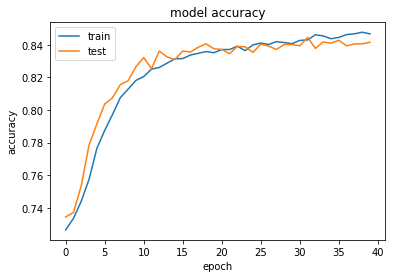

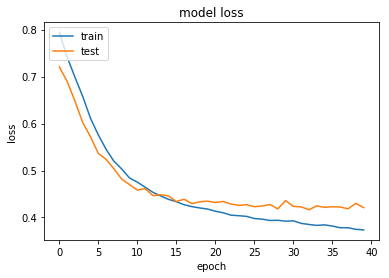

In [39]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()